In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829219 sha256=f9fa45ae2140a65e417c689d03ac37595da21c5a4d53db0c2229e54c0c40c77b
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [ ]:
# Google Colab Imports
from google.colab import drive
from google.colab import files

# Standard Library Imports
import os
import re
from typing import Dict, List, Tuple
from collections import Counter
import zipfile


# Data Manipulation and Numerical Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px

# Sparse Matrix Libraries
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.stats import mode

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Progress Tracking
from tqdm import tqdm

# Sentence Embeddings
from sentence_transformers import SentenceTransformer

# LightFM Libraries
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

In [ ]:
sns.set()

# Introduction 🍿

In this notebook, we document our approach to tackling the Recommendation System Challenge 🏆, a competition that predicts movie ratings using a curated sample of the MovieLens 🎬 32M dataset. Our strategy was designed to meet the baseline requirements and exceed expectations by incorporating innovative techniques, leveraging metadata, and ensuring explainability in our models.

---



# Our Approach 🎥


---



To address the challenge, we implemented the following key steps:

#### 1. **Data Exploration and Preprocessing**:
   - Conducted an extensive **EDA** in a separate notebook to uncover valuable insights and information about our data
   - user-item interaction patterns
   - metadata distributions
   - extracted year using regex and used it as a feature
   - user - genre preferences
   - item - genre preferences
   - clustering (Tags)
   - Identify users who consistently give the same rate
   - For more information take a look at the EDA notebook

#### 2. **Our Model**:
   - We built a customized, improved NeuMF architecture that fused user and item embeddings with metadata (e.g., genres, year, statistics).
   - leveraged unsupervised learning and created **pre-trained embeddings** for users and movies. Those embeddings were Incorporated into our model to further enrich the feature space. This addition produced exciting improvement which we visualized and discussed later.

#### 3. **Losses**:
  - implemented the required WRMSE loss.
  - implemented an additional weighed cross-entropy loss
  - We experimented with two loss functions to find the best combination, with the final loss calculated as $α * WRMSE + (1-α)WCE$.

#### 4. **Evaluation and Explainability**:
   - Evaluated model performance using the WRMSE and WCE metrics.
   - We enhanced explainability by conducting an ablation study and examining how each new component (added or changed in our NeuMf) influenced the final predictions.

#### 5. **Innovation and Iteration**: 🚀
   - We modified the original NeuMF model by changing and adding new components.
   - Incorpurated metadata such as item and user genres and year.
  - Conducted experiments using sentence transformer embeddings for movie titles and trained costume autoencoder to reduce dimensionality.
   - Utilized contrastive learning in an unsupervised setting to pretrain embeddings for items and movies.

# Data Loading 📦
---


✳️ train.csv - the training set

✳️ ratings_submission.csv - a sample submission file in the correct format

✳️ movies.csv - a dataset with metadata about the movies

✳️ tags.csv - a dataset with user-defined tags for the movies

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/RecSys Competition data'

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
movies_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/preprocess data/movies_df.csv')
tags_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/preprocess data/tags_df.csv')
train_unrated_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/preprocess data/train_unrated_df.csv')
train_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/preprocess data/train_df.csv')

In [ ]:
submission_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/ratings_submission.csv')

# **Exploratory Data Analysis** 👩‍💻


---
This notebook was too long, so we decided to split our EDA to an additional notebook.

We performed an extensive EDA, which you can here: [EDA Notebook ](https://colab.research.google.com/drive/1EDzLd6BKYg6yVXD8Y0W8rFuocMgVxTIa?usp=sharing)


# Data Preprocessing 👨‍🔬


---

In this section, we prepare the data for training and evaluation.

Key preprocessing steps include:

1️⃣ Simple Preprocessing

2️⃣ Statistics

3️⃣ DataLoader

### Simplt Preprocessing

In [ ]:
def set_random_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)

  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_random_seed(42)

In [ ]:
def create_user_genre_preferences():
  # Create a dict to store cumulative genre counts for each user
  user_genre_counts = {}
  user_movie_counts = {}

  # Iter over user-movie data
  i = 0
  for _, row in train_df.iterrows():

      if i % 100000==0:
        print("progress:", i / len(train_df))

      user_idx = row["user_idx"]
      movie_idx = row["movie_idx"]

      # Get the genre vector for the movie
      genre_vector = genres.loc[genres["movie_idx"] == movie_idx].iloc[:, :-1].values
      genre_vector = genre_vector[0]  # Extract the vector from the DataFrame slice

      # Update user's genre counts
      if user_idx not in user_genre_counts:
          user_genre_counts[user_idx] = genre_vector
          user_movie_counts[user_idx] = 1
      else:
          user_genre_counts[user_idx] += genre_vector
          user_movie_counts[user_idx] += 1
      i+=1

  # Normalize the accumulated counts to compute averages
  user_genre_preferences = {}
  for user_idx, genre_counts in user_genre_counts.items():
      total_movies = user_movie_counts[user_idx]
      user_genre_preferences[user_idx] = genre_counts / total_movies

  # Convert to DF for easier analysis
  user_genre_preferences_df = pd.DataFrame.from_dict(user_genre_preferences, orient="index", columns=genres.columns[1:])
  modified_user_genre_preferences_df = user_genre_preferences_df.drop(columns=["year", "movie_idx"])
  modified_user_genre_preferences_df["user_idx"] = modified_user_genre_preferences_df.index
  modified_user_genre_preferences_df.to_csv('/content/drive/MyDrive/RecSys Competition data/mapping/user_genre_preferences.csv', index=False)
  return modified_user_genre_preferences_df

In [ ]:
# We're interested in unique (user, item) pairs
original_train_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/train.csv')
original_train_df.drop_duplicates(subset=['user_id', 'movie_id'], inplace=True)
original_train_df['user_idx'] = pd.factorize(original_train_df['user_id'])[0]
original_train_df['movie_idx'] = pd.factorize(original_train_df['movie_id'])[0]

# Add movie_idx to movies_df
movies_df = movies_df.merge(original_train_df.drop_duplicates(subset=["movie_idx"])[['movie_id', 'movie_idx']], on='movie_id', how='left')
movies_df.drop(columns=['(no genres listed)', 'title', "num_genres"], inplace=True)

In [ ]:
genres = movies_df.drop(columns=["movie_id"])
deduped_train_df = train_df.drop_duplicates(subset=['movie_id'])

In [ ]:
# Generating movie genres
genres_multihot = torch.zeros(2000, 20, device=device)

for _, row in genres.iterrows():
    movie_idx = row['movie_idx']
    # Convert the multi-hot encoding to a tensor and place it on the device
    genres_multihot[int(movie_idx)] = torch.tensor(row.drop(['movie_idx']).values, dtype=torch.float32, device=device)

In [ ]:
modified_user_genre_preferences_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/mapping/user_genre_preferences.csv')
user_genre_preferences = torch.tensor(
    modified_user_genre_preferences_df.values, dtype=torch.float32, device=device
)
user_genre_preferences.shape

torch.Size([100000, 18])

In [ ]:
# Preprocess train_df
train_df.drop(columns=['tag'], inplace=True)
train_df.drop_duplicates(subset=['user_id', 'movie_id'], inplace=True)
train_df.reset_index(drop=True, inplace=True)

train_df.drop(columns=['user_idx', "movie_idx"], inplace=True)
train_df['user_idx'] = pd.factorize(train_df['user_id'])[0]
train_df['movie_idx'] = pd.factorize(train_df['movie_id'])[0]

In [ ]:
def add_user_item_weights(df: pd.DataFrame) -> pd.DataFrame:

    # Step 1: Count total ratings for movies
    movie_rating_counts = df.groupby('movie_id').size()

    # Step 2: Count total ratings for users
    user_rating_counts = df.groupby('user_id').size()

    # Step 3: Compute movie and user weights
    movie_weights = 1 / np.sqrt(movie_rating_counts)
    user_weights = 1 / np.sqrt(user_rating_counts)

    # Step 4: Map weights back to the DataFrame
    movie_weight_dict = movie_weights.to_dict()
    user_weight_dict = user_weights.to_dict()

    df['movie_weights'] = df['movie_id'].map(movie_weight_dict)
    df['user_weights'] = df['user_id'].map(user_weight_dict)

    # Step 5: Combine weights
    df['combined_weights'] = df['movie_weights'] #* df['user_weights']

    # Step 6: Normalize the combined weights
    min_weight = df['combined_weights'].min()
    max_weight = df['combined_weights'].max()
    df['normalized_weights'] = (df['combined_weights'] - min_weight) / (max_weight - min_weight)

In [ ]:
add_user_item_weights(train_df)
train_df.head(5)

,user_id,movie_id,rating,has_rating,tag_all_tags,user_idx,movie_idx,movie_weights,user_weights,combined_weights,normalized_weights
0,0,31,2.0,1,NaN,0,0,0.012010,0.069338,0.012010,0.201850
1,0,37,4.0,1,NaN,0,1,0.007381,0.069338,0.007381,0.040602
2,0,38,3.0,1,NaN,0,2,0.016664,0.069338,0.016664,0.363993
3,0,58,3.5,1,NaN,0,3,0.014781,0.069338,0.014781,0.298391
4,0,160,3.5,1,NaN,0,4,0.019422,0.069338,0.019422,0.460060


In [ ]:
movie_id_to_idx = dict(zip(train_df['movie_id'], train_df['movie_idx']))
user_id_to_idx = dict(zip(train_df['user_id'], train_df['user_idx']))

### **User & item statistics**
In this section, we compute statistical features for each user and movie . Here’s what we did:

- **Compute User Statistics:**  We group the dataset by user_id 👨‍💼 to calculate the statistics for each user using the compute_statistics function.

- **Compute Movie Statistics:**  Similarly, we group the dataset by movie_id 🎞 to calculate the statistics for each movie.

**Statistics calculated:**

ℹ️ mode

ℹ️  mean

ℹ️  median

↔️  range

⬇️  min

⬆️  max

ℹ️  std

ℹ️  variance

These statistics  were added as a features to our NeuMF model.
`user_statistics` $\in \mathbb{R^8}$, and `item_statistics` $\in \mathbb{R^8}$ were project through a linear layer $(\mathbb{R^8} → \mathbb{R^1})$ to create `item_bias` and `user_bias`, which was added to the rating prediction. Results were surprisingly good! We got a significant decrease in rmse, which took us from the $6^{th}$ place to the $3^{rd}$ in the leaderboard!

While intuitively, we thought that the user and item embeddings learned by NeuMF should already include these biases, this technique optimized our model significantly to our surprise.

We added an ablation study in the appendix at the bottom of the notebook, examining the effect of this part as well.


In [ ]:
def compute_statistics(group):
    """Calc statistical features for a group of ratings."""
    ratings = group['rating'].to_numpy()
    return pd.Series({
        'mean': np.mean(ratings)/5,
        'min': np.min(ratings)/5,
        'max': np.max(ratings)/5,
        'median': np.median(ratings)/5,
        'std': np.std(ratings, ddof=1),  # Sample standard deviation
        'variance': np.var(ratings, ddof=1)/5,  # Sample variance /5
        'mode': mode(ratings, nan_policy='omit').mode/5,
        'range': np.ptp(ratings)/5,  # Range (max - min) /5
    })

In [ ]:
# Compute statistics for users
user_stats_list = []
for user_id, group in tqdm(train_df.groupby('user_id'), desc="Processing Users"):
    stats = compute_statistics(group)
    stats['user_id'] = user_id  # Add user_id back for reference
    user_stats_list.append(stats)

user_stats = pd.DataFrame(user_stats_list)

# Compute statistics for movies
movie_stats_list = []
for movie_id, group in tqdm(train_df.groupby('movie_id'), desc="Processing Movies"):
    stats = compute_statistics(group)
    stats['movie_id'] = movie_id  # Add movie_id back for reference
    movie_stats_list.append(stats)

movie_stats = pd.DataFrame(movie_stats_list)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
user_tensor = torch.tensor(user_stats.drop(columns=['user_id']).to_numpy(), dtype=torch.float32).to(device)
movie_tensor = torch.tensor(movie_stats.drop(columns=['movie_id']).to_numpy(), dtype=torch.float32).to(device)

print("User Tensor on Device:", user_tensor.device)
print(user_tensor)

print("\nMovie Tensor on Device:", movie_tensor.device)
print(movie_tensor)

Processing Movies: 100%|██████████| 2000/2000 [00:04<00:00, 423.17it/s]


User Tensor on Device: cuda:0
tensor([[0.5774, 0.1000, 1.0000,  ..., 0.1175, 0.6000, 0.9000],
        [0.7261, 0.2000, 1.0000,  ..., 0.3692, 0.9000, 0.8000],
        [0.8381, 0.2000, 1.0000,  ..., 0.2324, 1.0000, 0.8000],
        ...,
        [0.7946, 0.4000, 1.0000,  ..., 0.0839, 0.8000, 0.6000],
        [0.6405, 0.1000, 1.0000,  ..., 0.7263, 1.0000, 0.9000],
        [0.7494, 0.1000, 1.0000,  ..., 0.2234, 0.9000, 0.9000]],
       device='cuda:0')

Movie Tensor on Device: cuda:0
tensor([[0.6808, 0.1000, 1.0000,  ..., 0.1564, 0.6000, 0.9000],
        [0.7290, 0.1000, 1.0000,  ..., 0.1591, 0.8000, 0.9000],
        [0.5777, 0.1000, 1.0000,  ..., 0.1905, 0.6000, 0.9000],
        ...,
        [0.7873, 0.1000, 1.0000,  ..., 0.1604, 0.8000, 0.9000],
        [0.7470, 0.1000, 1.0000,  ..., 0.2088, 0.8000, 0.9000],
        [0.8053, 0.1000, 1.0000,  ..., 0.1925, 1.0000, 0.9000]],
       device='cuda:0')


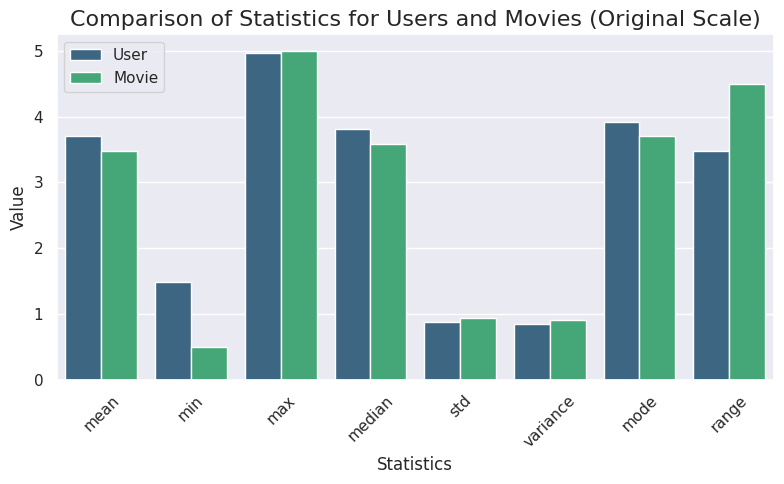

In [ ]:
# Identify the statistics that were divided by 5
divided_stats = ['mean', 'min', 'max', 'mode', 'median', 'variance', 'range']

# Reverse the division by 5 for only the affected statistics
user_plot_data = user_stats.drop(columns=['user_id']).mean()
movie_plot_data = movie_stats.drop(columns=['movie_id']).mean()

# Multiply only the affected statistics by 5
user_plot_data[divided_stats] *= 5
movie_plot_data[divided_stats] *= 5


stats_df = pd.DataFrame({
    'Statistic': user_plot_data.index,
    'User': user_plot_data.values,
    'Movie': movie_plot_data.values
}).melt(id_vars='Statistic', var_name='Entity', value_name='Value')

# Two side-by-side bar plots
plt.figure(figsize=(8, 5))
sns.barplot(
    data=stats_df,
    x='Statistic',
    y='Value',
    hue='Entity',
    palette='viridis'
)
plt.title("Comparison of Statistics for Users and Movies (Original Scale)", fontsize=16)
plt.ylabel("Value", fontsize=12)
plt.xlabel("Statistics", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### **Dataset, Dataloaders**

✅ We mapped user_id to user indices [0, 99,999]

✅ We mapped movie_id to movie indices [0, 1999]

✅ We weighted according to movie and user frequencies in train_df

✅ Our labels are both categorical [0, 9] and numerical [0.5, 5]

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(self, df: pd.DataFrame, user_id_to_idx, movie_id_to_idx, movie_tensor, user_tensor):
        self.n: int = len(df)

        self.user_ids = torch.tensor(df["user_id"].values)
        self.item_ids = torch.tensor(df["movie_id"].values)
        self.weights = torch.tensor(df["normalized_weights"].values)
        self.scores = torch.tensor(df["rating"].values.astype(np.float32))
        self.classes = torch.tensor(((df["rating"].values-0.5)*2).astype(int))
        self.item_features = movie_tensor
        self.user_features = user_tensor

        self.user_id_to_idx = user_id_to_idx
        self.movie_id_to_idx = movie_id_to_idx

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        user_ids = self.user_ids[idx].item()
        item_ids = self.item_ids[idx].item()
        weights = self.weights[idx].item()

        item_idx = self.movie_id_to_idx[item_ids]
        user_idx = self.user_id_to_idx[user_ids]
        scores = self.scores[idx]
        class_label = self.classes[idx]
        item_features = self.item_features[item_idx]
        user_features = self.user_features[user_idx]

        return user_idx, item_idx, weights, item_features, user_features, scores, class_label

In [ ]:
batch_size = 32

# Init the MovieLensDataset
dataset = MovieLensDataset(train_df, user_id_to_idx, movie_id_to_idx, movie_tensor, user_tensor)

# Create the DL
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
# Split dataset into training and validation
validation_split = 0

dataset_size = len(dataset)
val_size = int(dataset_size * validation_split)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Pre-Training 🧹

---


In this section, we discuss the process and results of pretraining embeddings for both users and items, as well as additional features and Tags clustring.

## Learning User Interactions and Pretraining Embeddings

To enhance the performance of our recommendation system, we explored multiple approaches for learning user interactions and pretraining feature embeddings:

-------
**Learning User Interactions**

We evaluated two methods to define positive and negative interactions in the dataset:

1. Treat All Interactions as Positive:

  In this approach, we considered all interactions in the training dataset as positive, regardless of whether the user rated the movie or not.
  Any movies that a user did not interact with were treated as negative.

2. Treat Only Rated Movies as Positive:

  Here, we treated only movies that the user explicitly rated as positive interactions.All other movies, including those watched but not rated, were treated as negative.

Results:

To our surprise, after testing both approaches, we found that the second method performed significantly better. Perehaps in our case explicit ratings provided clearer and more reliable signals of user preferences compared to implicit interactions, which might not always indicate satisfaction.

-----
**Pretraining Item and User Embeddings**

To initialize the NeuMF model, we pretrained item and user embeddings using collaborative filtering with a pairwise loss function. Specifically, we used the Weighted Approximate-Rank Pairwise (WARP) loss, which significantly outperformed the Bayesian Personalized Ranking (BPR) loss in our experiments.

**Impact:**
Super significant!!!

Pretraining the embeddings optimized our model's weighted RMSE, improving it from 0.87 to 0.83.


#### Positive Interactions Generation

In [ ]:
# Positive interactions are interactions where user rated a movie.
# We experimented with unrated movies as well, which worked worse.
positive_interactions = train_df[train_df['rating'].notnull()]
positive_interactions.head()

,user_id,movie_id,rating,has_rating,tag_all_tags,user_idx,movie_idx,tag
0,0,31,2.0,1,NaN,0,22,NaN
1,0,37,4.0,1,NaN,0,24,NaN
2,0,38,3.0,1,NaN,0,25,NaN
3,0,58,3.5,1,NaN,0,35,NaN
4,0,160,3.5,1,NaN,0,70,NaN


In [ ]:
# Get unique users and items
all_users = train_df['user_idx'].unique()
all_items = train_df['movie_idx'].unique()

# Create user-item pairs
user_item_set = set(zip(positive_interactions['user_idx'], positive_interactions['movie_idx']))

count = 10
for i, (user, item) in enumerate(user_item_set):
  print((user, item))
  if i == count:
    break

(73253, 625)
(90092, 1449)
(75873, 154)
(13629, 1578)
(47397, 490)
(80922, 398)
(36445, 255)
(91469, 547)
(71171, 1122)
(32200, 1499)
(33974, 68)


### Negative Interactions Generation

In [ ]:
# Generate negative samples
negative_samples = []
for user_idx in all_users:
    if user_idx % 10000 == 0:
      print(f"{user_idx}/{len(all_users)}")
    positive_items = positive_interactions[positive_interactions['user_idx'] == user_idx]['movie_idx'].values
    negative_items = np.setdiff1d(all_items, positive_items)
    if len(positive_items) > len(negative_items):
      print(f"{len(positive_items)}>{len(negative_items)} for user {user_idx}")
    sampled_negatives = np.random.choice(negative_items, size=len(positive_items), replace=False)
    for neg_item in sampled_negatives:
        negative_samples.append((user_idx, neg_item))

# Create DataFrame of negative samples
negative_df = pd.DataFrame(negative_samples, columns=['user_idx', 'movie_idx'])
negative_df.head()

0/100000


,user_idx,movie_idx
0,0,692
1,0,237
2,0,1155
3,0,470
4,0,1648


In [ ]:
positive_interactions['label'] = 1  # Label positive samples
negative_df['label'] = 0            # Label negative samples
train_data = pd.concat([positive_interactions, negative_df], ignore_index=True)

### Interaction Matrix Generation [100k, 2k]

In [ ]:
def create_interactions_matrix(train_data):
  dataset = Dataset()
  dataset.fit(train_data['user_idx'], train_data['movie_idx'])

  # Build interaction matrix
  interactions, _ = dataset.build_interactions(
      [(row['user_idx'], row['movie_idx']) for _, row in positive_interactions.iterrows()]
  )
def save_interactions_matrix(interactions):
  # Save it locally
  interactions_local_path = '/content/interactions_matrix.npz'
  save_npz(interactions_local_path, interactions)
  zip_local_path = '/content/interactions_matrix.zip'
  with zipfile.ZipFile(zip_local_path, 'w') as zipf:
      zipf.write(interactions_local_path, 'interactions_matrix.npz')

  # Move to drive
  !mv {zip_local_path} '/content/drive/MyDrive/RecSys Competition data/interactions_matrix.zip'

#interactions = create_interactions_matrix(train_data)
#save_interactions_matrix(interactions)

In [ ]:
def load_interactions_matrix():
  zip_path = '/content/drive/MyDrive/RecSys Competition data/interactions_matrix.zip'
  extract_dir = '/content/'

  # Extract the zip file
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)
  interactions = load_npz('/content/interactions_matrix.npz')

  # Check the loaded matrix
  print(interactions.shape)
  return interactions
interactions = load_interactions_matrix()

(100000, 2000)


### Training
- Warp loss worked best (significantly better than bpr)
- item and user features chosen is 30
- Multiple learning rates were examined, 0.1 worked best for us
- Loss converges after ~25 epochs, slowly increasing until the 50th epoch
- We used weight decay, decreasing x10 evenly over 50 epochs
- Evaluation Metrics:
  - Precision@5
  - Area under curve

In [ ]:
model = LightFM(loss='warp', no_components=30, learning_rate=0.1, random_state=42)
model.fit(interactions, epochs=50, num_threads=4, verbose=True)

precision = precision_at_k(model, interactions, k=5).mean()
# Sadly we lost this graph last minute... :(
# But AUC was ~0.85 the first epoch, and converging to ~0.92 at the last epoch.
auc = auc_score(model, interactions, ).mean()
print(f"Precision at k=5: {precision:.4f}, AUC Score: {auc:.4f}")

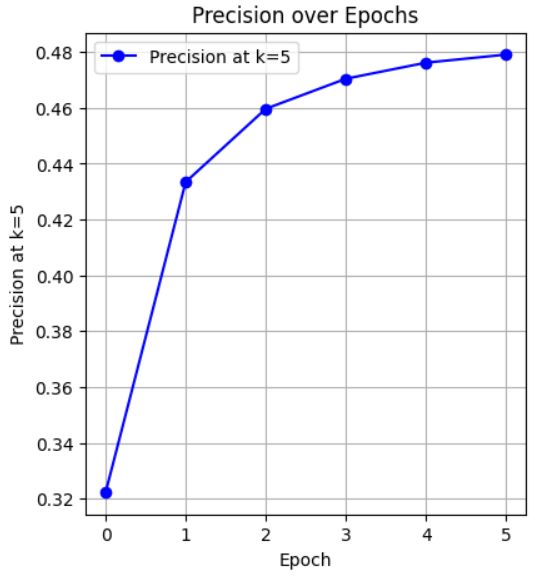

In [ ]:
# Parameters
initial_lr = 0.1  # Starting learning rate
final_lr = 0.01   # Desired final learning rate
epochs = 50       # Total number of epochs
decay_rate = (final_lr / initial_lr) ** (1 / epochs)  # Calculate decay rate

# Create the LightFM model
model = LightFM(loss='warp', no_components=15, learning_rate=initial_lr, random_state=42)

# Lists to store evaluation results
precision_list = []
auc_list = []

# Training loop with learning rate decay
for epoch in range(epochs+1):
    # Train for 1 epoch
    model.fit_partial(interactions, epochs=1, num_threads=4, verbose=True)

    # Evaluate metrics at certain intervals
    if epoch % 5 == 0:
        precision = precision_at_k(model, interactions, k=5).mean()
        auc = auc_score(model, interactions).mean()

        # Store metrics
        precision_list.append(precision)
        auc_list.append(auc)

        # Print metrics
        print(f"Epoch {epoch + 1}: Precision at k=5: {precision:.4f}, AUC Score: {auc:.4f}")

    # Adjust the learning rate by reinitializing the model
    if epoch < epochs - 1:
        model.learning_rate *= decay_rate  # Decay learning rate

print("Training completed.")


In [ ]:
# Plot precision and recall over epochs
plt.figure(figsize=(10, 5))

# Plot Precision
plt.subplot(1, 2, 1)
plt.plot(range(6), precision_list, label='Precision at k=5', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision at k=5')
plt.title('Precision over Epochs')
plt.grid(True)
plt.legend()

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(range(6), auc_list, label='AUC', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Epochs')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Saving pretrained embeddings

In [ ]:
np.save('item_embeddings.npy', model.item_embeddings)
np.save('user_embeddings.npy', model.user_embeddings)

In [ ]:
filename = "embeddingsfilename.zip"
# Create a zip file containing both embeddings
with zipfile.ZipFile(filename, 'w') as zipf:
    zipf.write('item_embeddings.npy')
    zipf.write('user_embeddings.npy')

# Move zip file to Google Drive
!cp embeddingsfilename.zip "/content/drive/My Drive/RecSys Competition data/pretraining/"


### Loading pretrained user and item embeddings

In [ ]:
recsys_path = '/content/drive/My Drive/RecSys Competition data/pretraining'

In [ ]:
def load_pretrained_embeddings(recsys_path: str, filename: str):
  # Unzip the file
  with zipfile.ZipFile(f"{recsys_path}/{filename}", 'r') as zipf:
      zipf.extractall('/content/')

  # Load the embeddings
  item_embeddings = np.load('item_embeddings.npy')
  user_embeddings = np.load('user_embeddings.npy')

  print("user_embeddings.shape", user_embeddings.shape)
  print("item_embeddings.shape", item_embeddings.shape)

  return torch.tensor(item_embeddings, dtype=torch.float32, device=device), torch.tensor(user_embeddings, dtype=torch.float32, device=device)

In [ ]:
item_embeddings, user_embeddings = load_pretrained_embeddings(recsys_path, 'embeddings.zip')

# Architecture 📐


---


✅ **We created a custom NeuMF model**, which we expanded

✅ **Incorporated user genres and movie genres** in multiple innovative ways, which are described at detail in the appendix.

✅ **Incorporated user and item biases**, which significantly improved our results!
We performed an ablation study, which we added to the explainability section down below, visualizing how significant this addition was.

✅ **Incorporated movie year**. We extracted it from the titles using regex, and normalized with mean 0 and std 1. It was concatenated to the `movie_genre` vector as an additional feature.

**This is the version which worked best for us:**
  - We created a multi-hot encoding for each movie genre. 📽
  - We created a user genres embedding, counting frequencies over the training dataset for each user and for each genre, estimating the user's genre preferences. 📺
  - We created movie genres multihot encodings
  - We created custom item features regarding ratings: [mean, median, mode, std, variance, min, max, range]
  - We created custom user features regarding ratings: [mean, median, mode, std, variance, min, max, range]

  - **MLP Genre Biases:**
    - **Motivation**: genres are strong signals, which were indeed found helpful to improve our results
    - We concatenate the user and item genre embeddings.
    - Added a small MLP to generate.
    - calculate genre bias `genre_bias ∈ ℝ`
    - Add `genre_bias` to predicted score

  - **MLP User-Item Biases:**
    - **Motivation**: We noticed that our model indeed minimizes WRMSE, but rarely predict 5s or 1s and 2s. While 1s and 2s are'nt as common, 5s sure are! We believe it was being 'conservative', predicting scores close to the median score. Attempting to tackle this issue, we added this module:
    - We created a small linear regressor for users ($ℝ^8 → ℝ^1$)
    - We created a small linear regressor for item biases ($ℝ^8 → ℝ^1$)
    - No non linearities. Adding them resulted in suboptimal results.
    - added `item_bias` and `user_bias` to predicted score

- **GMF:**
We modified GMF section as well, in multiple different ways which we describe in the appendix. It didn't contribute to the final result, and we ended up discarding metadata from this module.


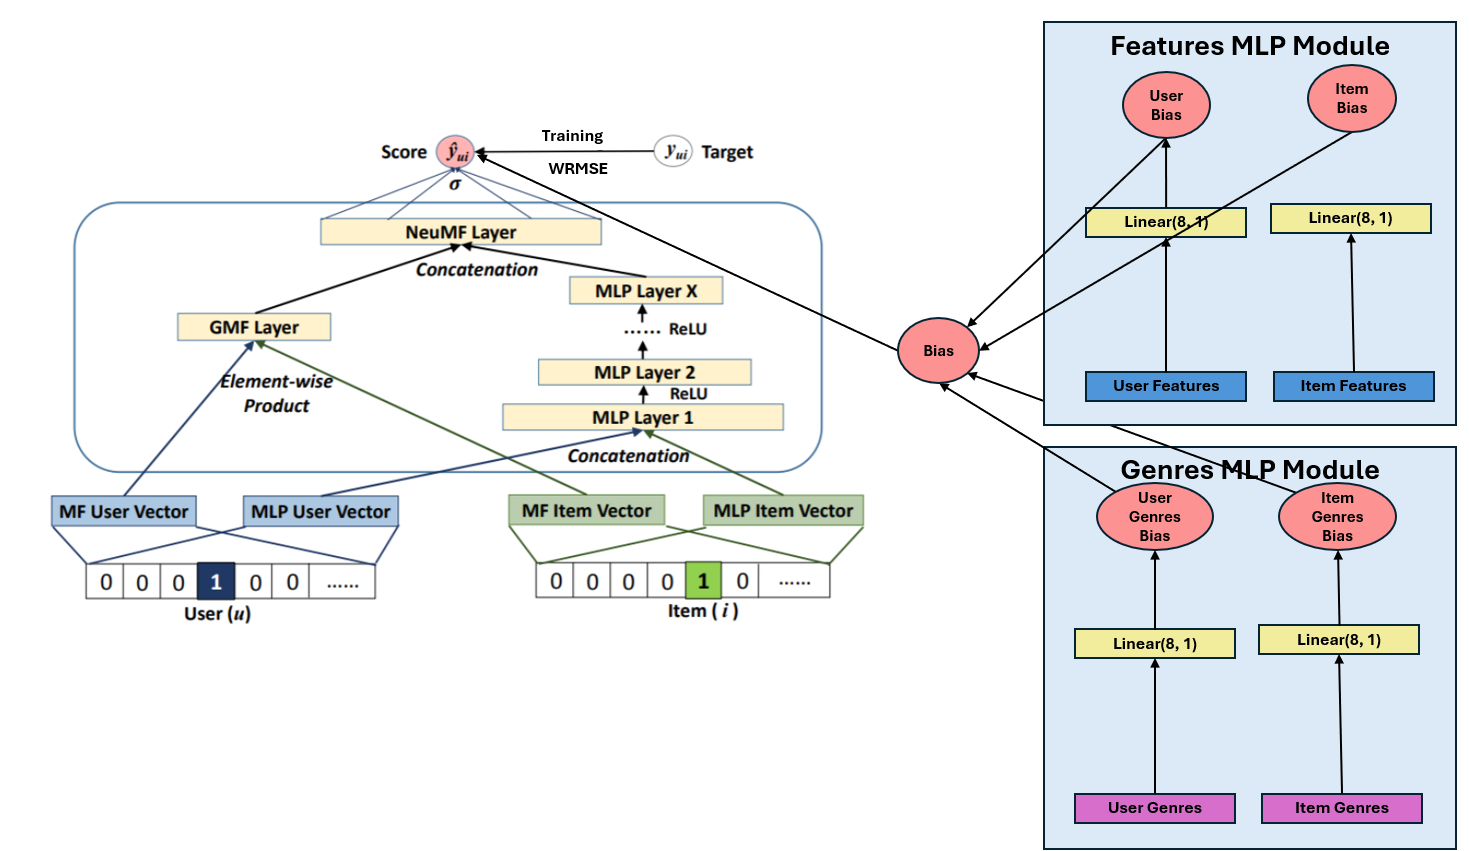

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim, mlp_layers, dropout=0.2, num_classes=10):
        """
        Parameters:
            num_users (int): Number of unique users.
            num_items (int): Number of unique items.
            embed_dim (int): Embedding dimension for GMF and MLP.
            mlp_layers (list): List containing the number of neurons for each MLP layer.
            dropout (float): Dropout rate for MLP layers.
        """
        super(NeuMF, self).__init__()

        # GMF embeddings
        self.gmf_user_embedding = nn.Embedding(num_users, embed_dim)
        self.gmf_item_embedding = nn.Embedding(num_items, embed_dim)
        #self.gmf_user_genre_fusion = nn.Sequential(nn.Linear(embed_dim + 18, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim))
        #self.gmf_item_genre_fusion = nn.Sequential(nn.Linear(embed_dim + 20, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim))

        # MLP embeddings
        self.mlp_user_embedding = nn.Embedding(num_users, embed_dim)
        self.mlp_item_embedding = nn.Embedding(num_items, embed_dim)

        # MLP layers
        mlp_input_dim = embed_dim * 2
        mlp_layers_seq = []
        for layer_size in mlp_layers:
            mlp_layers_seq.append(nn.Linear(mlp_input_dim, layer_size))
            mlp_layers_seq.append(nn.ReLU())
            mlp_layers_seq.append(nn.Dropout(dropout))
            mlp_input_dim = layer_size
        self.mlp_layers = nn.Sequential(*mlp_layers_seq)

        # Final prediction layer
        self.regression_predict_layer = nn.Linear(embed_dim + mlp_layers[-1], 1)
        self.classification_predict_layer = nn.Linear(embed_dim + mlp_layers[-1], num_classes)

        self.genres_predict_layer = nn.Sequential(nn.Linear(20 + 18, 10), nn.ReLU(), nn.Linear(10, 1))
        self.genres_fusion_layer = nn.Sequential(nn.Linear(20 + 18, 30))

        # self.user_bias_predict_layer = nn.Sequential(nn.Linear(8, 5), nn.ReLU(), nn.Linear(8, 1))
        # self.item_bias_predict_layer = nn.Sequential(nn.Linear(8, 5), nn.ReLU(), nn.Linear(8, 1))
        self.user_bias_predict_layer = nn.Sequential(nn.Linear(8, 1))
        self.item_bias_predict_layer = nn.Sequential(nn.Linear(8, 1))

        # Init
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.gmf_user_embedding.weight, std=0.01)
        nn.init.normal_(self.gmf_item_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_user_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embedding.weight, std=0.01)

        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        nn.init.xavier_uniform_(self.regression_predict_layer.weight)
        nn.init.zeros_(self.regression_predict_layer.bias)

        nn.init.xavier_uniform_(self.classification_predict_layer.weight)
        nn.init.zeros_(self.classification_predict_layer.bias)

    def forward(self, user_indices, item_indices, item_features, user_features):
        user_genres = user_genre_preferences[item_indices]
        item_genres = genres_multihot[item_indices]+1
        genres_combined = torch.cat((item_genres, user_genres), dim=-1)

        # GMF part
        gmf_user = self.gmf_user_embedding(user_indices)
        gmf_item = self.gmf_item_embedding(item_indices)
        #gmf_user_fused = self.gmf_user_genre_fusion(torch.cat((gmf_user, user_genres), dim=-1))
        #gmf_item_fused = self.gmf_item_genre_fusion(torch.cat((gmf_item, item_genres), dim=-1))
        gmf_output = gmf_user * gmf_item

        # MLP part
        mlp_user = self.mlp_user_embedding(user_indices)
        mlp_item = self.mlp_item_embedding(item_indices)
        mlp_input = torch.cat((mlp_item, mlp_user), dim=-1)
        mlp_output = self.mlp_layers(mlp_input)

        # Concatenate GMF and MLP outputs
        combined = torch.cat((gmf_output, mlp_output), dim=-1)

        genres_bias = self.genres_predict_layer(genres_combined)

        user_bias = self.user_bias_predict_layer(user_features)
        item_bias = self.item_bias_predict_layer(item_features)

        regression_prediction = self.regression_predict_layer(combined) + genres_bias + item_bias + user_bias
        classification_prediction = self.classification_predict_layer(combined)
        return regression_prediction, classification_prediction


# Loss Functions & Class Weights ⚖️
---

### Weighted RMSE Loss 🏋️‍♂️


$ W-RMSE =\sqrt \frac{\sum_{i=1}^nw_i(ŷ-y_i)^2}{\sum_{i=1}^nw_i} $

where $w_i = \frac{1}{\sqrt{Total - ratings - of - the - movie}} $

In [ ]:
class WeightedRMSELoss(nn.Module):
    def __init__(self, eps=1e-6):  # Add epsilon for numerical stability
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y, weights):
        """
        Args:
            y_pred (torch.Tensor): Predicted values.
            y (torch.Tensor): Ground truth values.
            total_ratings (torch.Tensor): Number of ratings for each movie.
        """
        # Calc weighted squared differences
        weighted_mse = torch.sum(weights * (y_pred - y) ** 2) / torch.sum(weights)

        # Calc weighted RMSE
        return torch.sqrt(weighted_mse + self.eps)

### Weighted Cross Entropy Loss 🏋️


To address the mismatch between the predicted score distribution and the actual training data distribution, we introduced a second loss function to guide our model.

**Observed Discrepancy** 👀

The distribution of the scores predicted by our model was highly centralized:
Mean: 3.75, Median: 3.81, Std: 0.55.
In contrast, the actual training data had a much broader distribution:
Mean: 3.61, Median: 4, Std: 1.02.
This difference suggested that the model struggled to replicate the diversity of real user ratings, potentially leading to suboptimal predictions.

**Approach**

To align the predicted score distribution with the training data distribution, we experimented with a Weighted Cross-Entropy Loss combined with our Weighted RMSE loss function: $α\cdot wce + (1-α)\cdot wrmse $. The goal was to encourage the model to learn a probability distribution that better reflects the diversity in the training data, while still minimizing wrmse.

**Weighted Cross-Entropy:**

Assigned weights to scores based on their occurrence in the training data, emphasizing underrepresented scores.
KL Divergence Regularization:
Penalized the model when the predicted distribution deviated significantly from the observed distribution in the training data.

In [ ]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = class_weights

    def forward(self, y_pred, y):
        # return nn.CrossEntropyLoss(weight=self.class_weights)(y_pred, y)
        return nn.CrossEntropyLoss()(y_pred, y)

### Class weights 🏋️‍♀️

In [ ]:
def generate_class_weights():
  ratings = ((train_df['rating'].values-0.5)*2).astype(int)
  # Calc class weights based on rating counts
  rating_counts = Counter(ratings)
  max_count = max(rating_counts.values())

  # Calc class weights
  class_weights = {rating: max_count / count for rating, count in rating_counts.items()}

  # Sort the class_weights dictionary by the rating values to ensure order
  sorted_class_weights = sorted(class_weights.items(), key=lambda x: x[0])
  class_weights = torch.tensor([weight for _, weight in sorted_class_weights], dtype=torch.float).to(device)

  return class_weights

In [ ]:
class_weights = generate_class_weights()
print(class_weights)

tensor([20.7856, 11.1823, 18.9170,  4.7723,  5.6559,  1.5074,  2.0268,  1.0000,
         2.7243,  1.8241], device='cuda:0')


<ipython-input-34-051a6b167de5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratings, y=class_weights.detach().cpu().numpy(), palette="viridis")


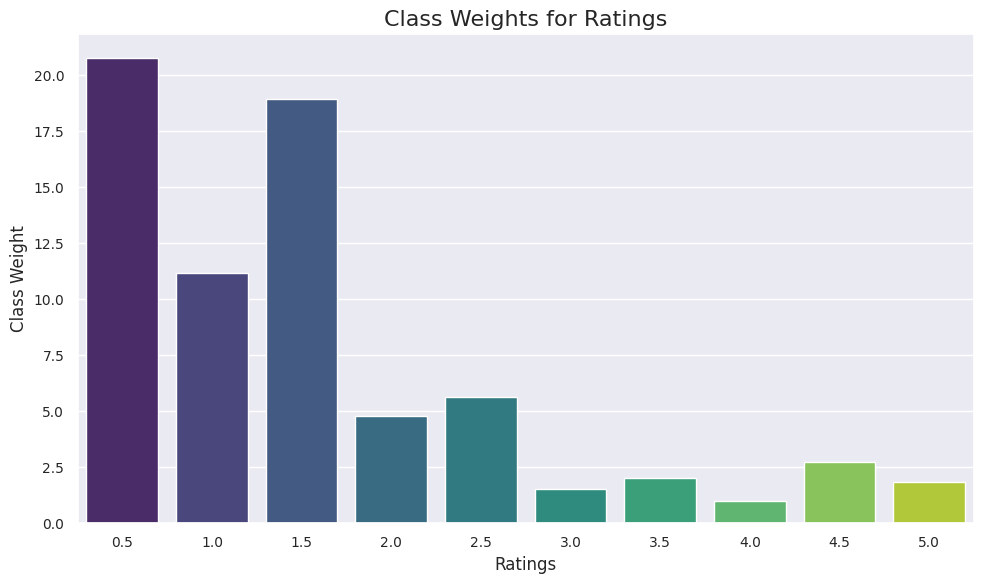

In [ ]:
ratings = [0.5 + 0.5 * i for i in range(len(class_weights))]

# Create a barplot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings, y=class_weights.detach().cpu().numpy(), palette="viridis")
plt.title("Class Weights for Ratings", fontsize=16)
plt.xlabel("Ratings", fontsize=12)
plt.ylabel("Class Weight", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Model Definition & Parameters 📝
---


In [ ]:
max_user_idx = train_df["user_idx"].max()
max_item_idx = train_df["movie_idx"].max()
print("max user idx:", max_user_idx)
print("max item idx:", max_item_idx)

In [ ]:
learning_rates = [0.001]
epochs = 2
factors = [0.7]
mlp_layer_lists = [[30]]
ce_weights = [0.2]
embed_dim = 30

# Load pretrained model weights (item, user embeddings)
pretrained_item_embeddings, pretrained_user_embeddings = load_pretrained_embeddings(recsys_path, "embeddings.zip")

# Training 🤸‍♀️


---

This section trains the recommendation model using the processed dataset. Key steps include:

1. Training the model using a custom loss function and optimizer.
2. Validating the model after each epoch to monitor performance and prevent overfitting.

We record key metrics, such as W-RMSE, to evaluate the model's progress across epochs.

In [ ]:
def train_neumf(model, learning_rate, ce_weight, factor, epochs):
  # Init model, loss function, and optimizer
  regression_criterion = WeightedRMSELoss()
  classification_criterion = WeightedCrossEntropyLoss(class_weights)

  # Weight the two loss functions
  classification_criterion_weight = ce_weight
  regression_criterion_weight = 1 - classification_criterion_weight
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Define the scheduler with a threshold
  scheduler = ReduceLROnPlateau(
      optimizer,
      mode='min',
      factor=factor,            # Reduce learning rate by a factor
      patience=1,            # How many epochs to wait before reducing LR
      threshold=0.003,        # Minimum change in metric to qualify as improvement
      min_lr=1e-5            # Minimum learning rate
  )

  model.to(device)

  print("Starting training...")

  # Init history for plotting
  train_rmse_losses = []
  train_ce_losses = []
  val_rmse_losses = []
  val_ce_losses = []

  best_val_loss = float('inf')  # Track the best validation loss
  patience_counter = 0  # Counter for early stopping

  for epoch in range(epochs):  # Add an epoch loop
      print(f"\nEpoch {epoch + 1}/{epochs}")
      running_rmse_loss = 0.0
      running_ce_loss = 0.0

      # Single epoch details
      total_batches = len(train_dataloader)
      validation_interval = total_batches // 10

      # Training loop
      model.train()

      # Create training progress bar
      with tqdm(total=total_batches, desc="Training", unit="batch") as pbar_train:

          # Create validation progress bar (initially at 0)
          pbar_val = tqdm(total=len(val_dataloader), desc="Validation", unit="batch", position=1, leave=False)


          for batch_idx, (user_indices, item_indices, weights, item_features, user_features, scores, labels) in enumerate(train_dataloader):
              model.train()
              user_indices, item_indices, weights, scores, item_features, user_features, labels = user_indices.to(device), item_indices.to(device), weights.to(device), scores.to(device), item_features.to(device), user_features.to(device), labels.to(device)

              # Zero gradients
              optimizer.zero_grad()

              # Forward pass
              regression_predictions, classification_predictions = model(user_indices, item_indices, item_features, user_features)
              regression_predictions, classification_predictions = regression_predictions.squeeze(), classification_predictions.squeeze()

              # Compute losses
              regression_loss = regression_criterion(regression_predictions, scores, weights)
              classification_loss = classification_criterion(classification_predictions, labels)

              # Compute total loss
              loss = regression_criterion_weight * regression_loss + classification_criterion_weight * classification_loss
              # scheduler.step(loss)  # Pass the weighted validation loss

              # Backward pass and optimizer step
              loss.backward()
              optimizer.step()

              # Accumulate losses
              running_rmse_loss += regression_loss.item()
              running_ce_loss += classification_loss.item()

              train_rmse_losses.append(running_rmse_loss / (batch_idx + 1))
              train_ce_losses.append(running_ce_loss / (batch_idx + 1))

              # Update training progress bar with individual losses
              pbar_train.set_postfix(
                  train_rmse_loss=running_rmse_loss / (batch_idx + 1),
                  train_ce_loss=running_ce_loss / (batch_idx + 1)
              )
              pbar_train.update(1)

              # Validation step after a fixed number of batches
              if (batch_idx + 1) % validation_interval == 0:
                  model.eval()  # Switch to evaluation mode
                  val_rmse_loss = 0.0
                  val_ce_loss = 0.0

                  # Validation loop
                  with torch.no_grad():
                      for val_user_indices, val_item_indices, val_weights, val_item_features, val_user_features, val_scores, val_labels in val_dataloader:
                          val_user_indices, val_item_indices, val_weights, val_item_features, val_user_features, val_scores, val_labels = val_user_indices.to(device), val_item_indices.to(device), val_weights.to(device), val_item_features.to(device), val_user_features.to(device), val_scores.to(device), val_labels.to(device)

                          val_regression_predictions, val_classification_predictions = model(val_user_indices, val_item_indices, val_item_features, val_user_features)
                          val_regression_predictions, val_classification_predictions = val_regression_predictions.squeeze(), val_classification_predictions.squeeze()

                          val_regression_loss = regression_criterion(val_regression_predictions, val_scores, val_weights)
                          val_classification_loss = classification_criterion(val_classification_predictions, val_labels)

                          val_rmse_loss += val_regression_loss.item()
                          val_ce_loss += val_classification_loss.item()

                  # AVG validation losses
                  avg_val_rmse_loss = val_rmse_loss / len(val_dataloader)
                  avg_val_ce_loss = val_ce_loss / len(val_dataloader)


                  val_rmse_losses.append(avg_val_rmse_loss)
                  val_ce_losses.append(avg_val_ce_loss)

                  scheduler.step(avg_val_rmse_loss)

                  # Update progress bar with val res
                  pbar_train.set_postfix(
                      train_rmse_loss=running_rmse_loss / (batch_idx + 1),
                      train_ce_loss=running_ce_loss / (batch_idx + 1),
                      val_rmse_loss=avg_val_rmse_loss,
                      val_ce_loss=avg_val_ce_loss
                  )

                  pbar_val.update(len(val_dataloader))  #

                  model.train()  # Switch back to training mode


          print(f"Training completed - Final Avg RMSE Loss: {running_rmse_loss / total_batches:.4f}")
          print(f"Training completed - Final Avg CE Loss: {running_ce_loss / total_batches:.4f}")

  return train_rmse_losses, train_ce_losses, val_rmse_losses, val_ce_losses

In [ ]:
for learning_rate in learning_rates:
  for ce_weight in ce_weights:
    for factor in factors:
      for mlp_layers in mlp_layer_lists:
        print(f"learning_rate={learning_rate}", f"factor={factor}", f"mlp_layers={mlp_layers}", f"ce_weight={ce_weight}")
        # Hyperparameters

        model = NeuMF(
            num_users = max_user_idx + 1,
            num_items = max_item_idx + 1,
            embed_dim = embed_dim,
            mlp_layers = mlp_layers,
            dropout=0.2,
        ).to(device)

        # Load pretrained model weights (item, user embeddings)
        pretrained_item_embeddings, pretrained_user_embeddings = load_pretrained_embeddings(recsys_path, "embeddings.zip")

        model.gmf_user_embedding.weight.data.copy_(pretrained_user_embeddings)
        model.gmf_item_embedding.weight.data.copy_(pretrained_item_embeddings)

        model.mlp_user_embedding.weight.data.copy_(pretrained_user_embeddings)
        model.mlp_item_embedding.weight.data.copy_(pretrained_item_embeddings)

       train_rmse_losses, train_ce_losses, val_rmse_losses, val_ce_losses = train_neumf(model, learning_rate, ce_weight, factor, epochs)
       plot_losses(train_rmse_losses, train_ce_losses, val_rmse_losses, val_ce_losses)

learning_rate=0.001 factor=0.4 mlp_layers=[30] ce_weight=0.2
user_embeddings.shape (100000, 30)
item_embeddings.shape (2000, 30)
Starting training...

Epoch 1/2


Training: 100%|██████████| 228230/228230 [31:02<00:00, 122.55batch/s, train_ce_loss=1.63, train_rmse_loss=0.797]


Learning rate adjusted by factor 0.4 after the first epoch.
Epoch 1 completed - Avg RMSE Loss: 0.7971
Epoch 1 completed - Avg CE Loss: 1.6344

Epoch 2/2


Training: 100%|██████████| 228230/228230 [31:29<00:00, 120.82batch/s, train_ce_loss=1.5, train_rmse_loss=0.729]

Epoch 2 completed - Avg RMSE Loss: 0.7286
Epoch 2 completed - Avg CE Loss: 1.4988


In [ ]:
def plot_losses(train_rmse_losses, train_ce_losses, val_rmse_losses, val_ce_losses):
  # W-RMSE vs. Epochs
  plt.figure(figsize=(12, 6))

  # Plot training losses
  plt.plot(train_rmse_losses, label="Train RMSE Loss", color="blue", alpha=0.7)
  plt.plot(train_ce_losses, label="Train CE Loss", color="green", alpha=0.7)

  # # Plot val losses
  # plt.plot(val_rmse_losses, label="Validation RMSE Loss", color="c", linestyle="--", alpha=0.7)
  # plt.plot(val_ce_losses, label="Validation CE Loss", color="green", linestyle="--", alpha=0.7)

  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Losses Over Time")
  plt.legend()
  plt.show()

# Inference 🔮

---

For the inference stage, we use our trained model to predict ratings for each user-movie pair in the test set. The output is formatted as specified by the contest, ensuring compatibility with the submission requirements.



In [ ]:
def submission_df_preprocessing(submission_df: pd.DataFrame):
  submission_df[['user_id', 'movie_id']] = submission_df['id'].str.split('_', expand=True)
  submission_df['user_id'] = submission_df['user_id'].astype(int)
  submission_df['movie_id'] = submission_df['movie_id'].astype(int)

In [ ]:
def submission_df_postprocessing(submission_df: pd.DataFrame):
  submission_df.drop(columns=['user_id', 'movie_id'], inplace=True)

In [ ]:
def save_submission(submission_df: pd.DataFrame, submission_name: str):
  submission_df.to_csv(f'{data_path}/submissions/{submission_name}.csv', index=False)

In [ ]:
def predict_ratings(df: pd.DataFrame, model: NeuMF, user_id_to_idx, movie_id_to_idx):
  model.eval()
  with torch.no_grad():
    user_ids = df.user_id
    movie_ids = df.movie_id

    user_idx = torch.tensor(np.array([user_id_to_idx[user_id] for user_id in df.user_id]))
    movie_idx = torch.tensor(np.array([movie_id_to_idx[movie_id] for movie_id in df.movie_id]))

    movie_idx = movie_idx.to(device)
    user_idx = user_idx.to(device)

    movie_features = movie_tensor[movie_idx].to(device)
    user_features = user_tensor[user_idx].to(device)
    predicted_scores, _ = model(user_idx, movie_idx, movie_features, user_features)

    print("predicted_scores", predicted_scores)
    clamped_predictions = torch.clamp(predicted_scores, 0.5, 5.0)
    aligned_predictions = torch.round(clamped_predictions / 0.5) * 0.5
    df['prediction'] = aligned_predictions.cpu().detach().numpy()

In [ ]:
submission_df_preprocessing(submission_df)
predict_ratings(submission_df, model, user_id_to_idx, movie_id_to_idx)
submission_df_postprocessing(submission_df)
# save_submission(submission_df, "submission26")

predicted_scores tensor([[3.4941],
        [3.2975],
        [4.0355],
        ...,
        [4.1958],
        [2.3613],
        [3.7298]], device='cuda:0')


### 🔄 Change the rate for users with only one singel score

In [ ]:
  submission_df[['user_id', 'movie_id']] = submission_df['id'].str.split('_', expand=True)
  submission_df['user_id'] = submission_df['user_id'].astype(int)
  submission_df['movie_id'] = submission_df['movie_id'].astype(int)

In [ ]:
# Count for each user how many uniqe ratings he have
user_rating_counts = train_df.groupby('user_id')['rating'].apply(lambda x: Counter(x).keys()).reset_index()
user_rating_counts['score_count'] = user_rating_counts['rating'].apply(len)

# Identify users with a single unique rating
single_score_users = user_rating_counts[user_rating_counts['score_count'] == 1]

single_score_map = {
    row['user_id']: list(row['rating'])[0]
    for _, row in single_score_users.iterrows()
}

# Update the submission DF
submission_df['prediction'] = submission_df.apply(
    lambda row: single_score_map[row['user_id']]
    if row['user_id'] in single_score_map
    else row['prediction'],
    axis=1
)

In [ ]:
submission_df_postprocessing(submission_df)
save_submission(submission_df, "submission_new_8")

 ### 🔄 Change the rate for users with low std ratings (bellow TH)

In [ ]:
best_submission = pd.read_csv("/content/best-submission.csv")
best_submission

,id,prediction
0,0_1188,3.5
1,5_7163,3.5
2,8_460,4.0
3,9_3705,3.5
4,11_2650,3.0
...,...,...
99995,200938_859,3.5
99996,200953_69751,4.0
99997,200954_70276,4.0
99998,200955_33800,2.5


In [ ]:
# Group by 'user_id' to compute standard deviation and count of ratings for each user
user_rating_stats = train_df.groupby("user_id").agg(
    rating_std=("rating", "std"),
    rating_count=("rating", "size")
)

std_threshold = 0.2
user_rating_stats['rating_std'] = user_rating_stats['rating_std'].fillna(0)

# Filter users with low df below th
low_std_users = user_rating_stats[user_rating_stats["rating_std"] <= std_threshold]

# Count of such users and the num of ratings they provided
low_std_users_count = low_std_users.shape[0]
low_std_users_ratings_count = low_std_users["rating_count"].sum()

print(f"Number of users with low rating standard deviation (< {std_threshold}): {low_std_users_count}")
print(f"Total number of ratings made by these users: {low_std_users_ratings_count}")

Number of users with low rating standard deviation (< 0.2): 145
Total number of ratings made by these users: 7145


In [ ]:
best_submission = pd.read_csv("/content/best-submission.csv")

best_submission[['user_id', 'movie_id']] = best_submission['id'].str.split('_', expand=True)
best_submission['user_id'] = best_submission['user_id'].astype(int)
best_submission['movie_id'] = best_submission['movie_id'].astype(int)

user_rating_stats = train_df.groupby("user_id").agg(
    rating_std=("rating", "std"),
    rating_count=("rating", "size")
)

std_threshold = 0.5
user_rating_stats['rating_std'] = user_rating_stats['rating_std'].fillna(0)

# Filter users with low df below th
low_std_users = user_rating_stats[user_rating_stats["rating_std"] <= std_threshold]

# Get the user IDs of low_std_users
low_std_user_ids = low_std_users.index

# For each low_std_user, find the mode of their ratings
mode_ratings = train_df[train_df['user_id'].isin(low_std_user_ids)].groupby('user_id')['rating'].agg(lambda x: x.mode()[0])

# Override the predictions for these low_std_users
for user_id, mode_rating in mode_ratings.items():
    best_submission.loc[best_submission['user_id'] == user_id, 'prediction'] = mode_rating

best_submission['id'] = best_submission['user_id'].astype(str) + '_' + best_submission['movie_id'].astype(str)
best_submission = best_submission.drop(['user_id', 'movie_id'], axis=1)
best_submission.to_csv("/content/modified_best_submission.csv", index=False)

### **Probabilities Distributions Comparison - Ground Truth vs Estimated**

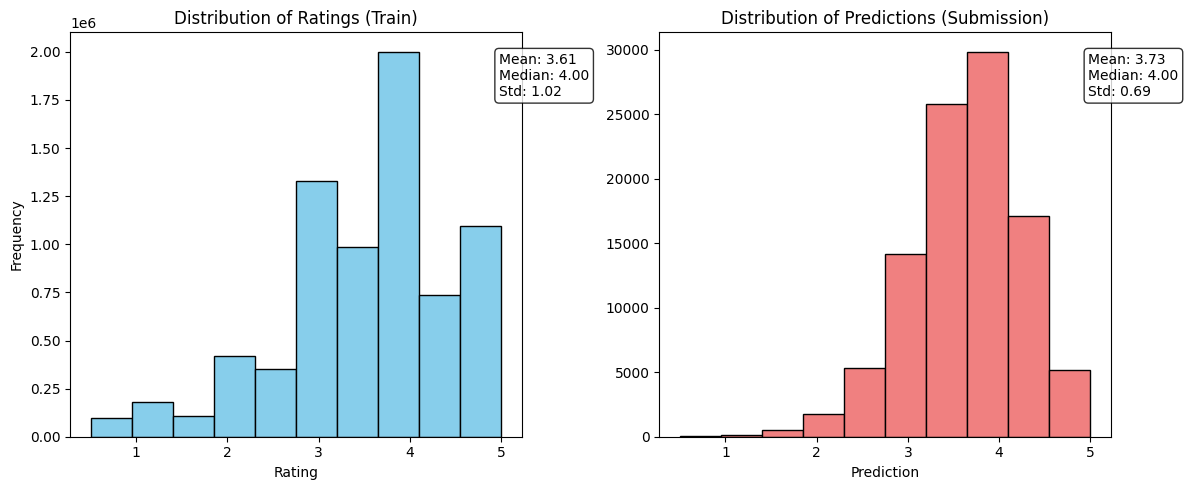

In [ ]:
train_mean = train_df['rating'].mean()
train_median = train_df['rating'].median()
train_std = train_df['rating'].std()

submission_mean = submission_df['prediction'].mean()
submission_median = submission_df['prediction'].median()
submission_std = submission_df['prediction'].std()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train DataFrame histogram
axes[0].hist(train_df['rating'], bins=10, edgecolor='black', color='skyblue')
axes[0].set_title('Distribution of Ratings (Train)')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].text(0.95, 0.95, f'Mean: {train_mean:.2f}\nMedian: {train_median:.2f}\nStd: {train_std:.2f}',
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1].hist(submission_df['prediction'], bins=10, edgecolor='black', color='lightcoral')
axes[1].set_title('Distribution of Predictions (Submission)')
axes[1].set_xlabel('Prediction')
axes[1].text(0.95, 0.95, f'Mean: {submission_mean:.2f}\nMedian: {submission_median:.2f}\nStd: {submission_std:.2f}',
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Metadata


---



## Feature Embeddings

- Tags
- Movie Titles
- Unrated Movies

we experimented with creating embeddings using sentence transformers for various features to enhance the model's performance. Specifically, we explored embeddings for the following features:

1. Tags:

  We generated embeddings for the tags associated with movies, aiming to capture additional semantic information.

2. Titles:

  We created embeddings based on the movie titles, leveraging text-based features to encode semantically meaningful representations.

3. Unrated Movies:

  We included a multi hot of movies that the user watched but did not rate, hypothesizing that these interactions could provide valuable implicit feedback.

** We trained an 3 custom autoencoders to project the embeddings to smaller dimension and concrete them to the user and item embedding

Results:

After testing all possible combinations of these embeddings with our model, we found that their inclusion consistently hurt the final results. The additional embeddings introduced noise or redundancies that outweighed their potential benefits. As a result, we concluded that this approach was not effective for improving our model, and we decided to exclude these embeddings from our final implementatio.

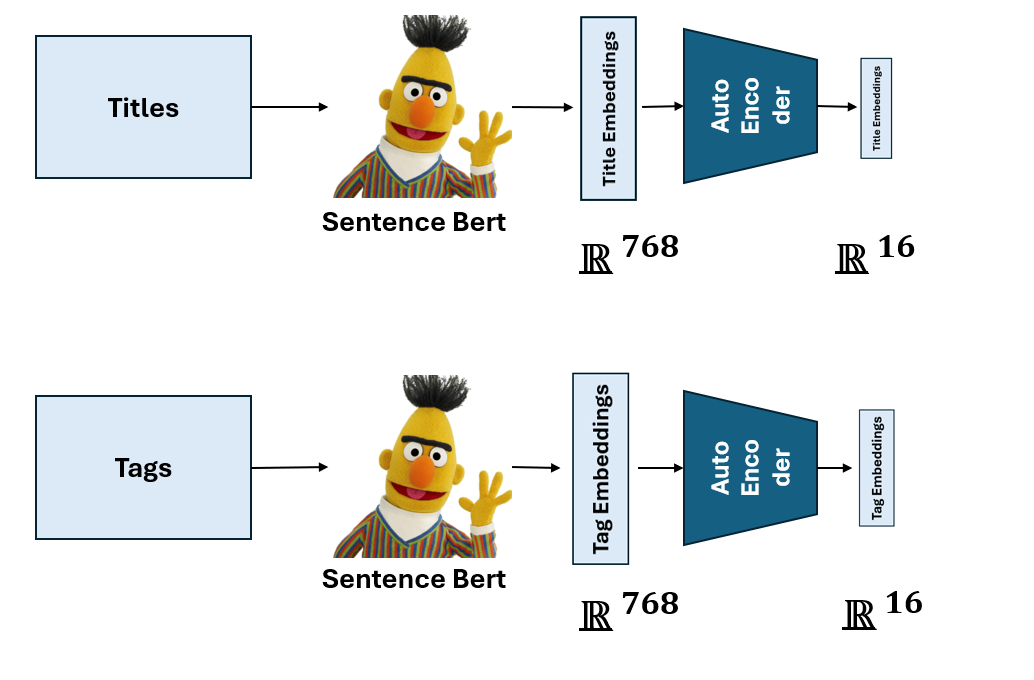

In [ ]:
def embed_titles(movies_df: pd.DataFrame, sentence_embedder: SentenceTransformer):
  print(f"Embedding {len(movies_df)} movie titles")
  folder_path = "/content/drive/My Drive/RecSys Competition data"
  embeddings_file_name = "title_embeddings"
  full_path = os.path.join(folder_path, embeddings_file_name)

  if os.path.exists(full_path):
    title_embeddings = np.load(full_path)
  else:
    titles = movies_df["title"].values
    title_embeddings = sentence_embedder.encode(titles)
    np.save(full_path, title_embeddings)

  torch_embeddings = torch.tensor(title_embeddings, dtype=torch.float32)
  return nn.Embedding.from_pretrained(torch_embeddings, freeze=False)

def embed_tags(tags_df: pd.DataFrame, sentence_embedder: SentenceTransformer) -> Dict[str, np.array]:
  unique_tags = tags_df["tag"].unique()
  tags_dict ={tag : index + 1 for index, tag in enumerate(unique_tags)}


  print(f"Embedding {len(unique_tags)} tags")
  folder_path = "/content/drive/My Drive/RecSys Competition data"
  embeddings_file_name = "tag_embeddings.npy"
  full_path = os.path.join(folder_path, embeddings_file_name)
  if os.path.exists(full_path):
    tag_embeddings = np.load(full_path)
  else:
    tag_embeddings = sentence_embedder.encode(unique_tags)
    np.save(full_path, tag_embeddings)

  torch_embeddings = torch.tensor(tag_embeddings, dtype=torch.float32)
  return nn.Embedding.from_pretrained(torch_embeddings, freeze=False), tags_dict

In [ ]:
def embed_data(movies_df: pd.DataFrame, tags_df: pd.DataFrame, train_unrated_df:pd.DataFrame, sentence_embedder: SentenceTransformer):
  title_embeddings = embed_titles(movies_df, sentence_embedder)
  tag_embeddings, tag_dict = embed_tags(tags_df, sentence_embedder)
  unrated_embeddings = embed_unrated_df(train_unrated_df)
  return title_embeddings, tag_embeddings,tag_dict ,unrated_embeddings

def embed_unrated_df(train_unrated_df: pd.DataFrame) -> Dict[str, np.array]:
  train_unrated_data = train_unrated_df.to_numpy()
  unrated_tensors = torch.tensor(train_unrated_data, dtype=torch.float32)
  return nn.Embedding.from_pretrained(unrated_tensors, freeze=False)

In [ ]:
unrated_vectors = train_unrated_df.to_numpy()
torch_embeddings = torch.tensor(unrated_vectors, dtype=torch.float32)
torch_embeddings.shape

In [ ]:
model_name = "all-mpnet-base-v2"
sentence_embedder = SentenceTransformer(model_name)
title_embeddings, tag_embeddings, tag_dict ,unrated_embeddings = embed_data(movies_df, tags_df, train_unrated_df, sentence_embedder)

### Embeddings Dimensionality Reduction

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return bottleneck, reconstructed

In [ ]:
def prepare_dataloader(data, batch_size, validation_split=0.2):
    """Prepares DataLoader for training and validation."""
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def train_autoencoder(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    """Trains the autoencoder model and evaluates on validation set."""
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            _, reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Val
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch[0].to(device)
                _, reconstructed = model(batch)
                loss = criterion(reconstructed, batch)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}")

def reduce_embeddings(model, data, device):
    """Reduces the dimensionality of embeddings using the trained autoencoder."""
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    with torch.no_grad():
        reduced_embeddings = model.encoder(data_tensor)
    return reduced_embeddings.cpu().numpy()

In [ ]:
def get_reduced_embeddings(title_embeddings, tag_embeddings, unrated_embeddings, bottleneck_dim=16, batch_size=8, num_epochs=5, learning_rate=0.001) -> Tuple[nn.Embedding, nn.Embedding]:
  reduced_title_embeddings   = auto_encoder_pipeline(title_embeddings, title_embeddings.weight.shape[1], bottleneck_dim, batch_size, num_epochs, learning_rate)
  reduced_tag_embeddings     = auto_encoder_pipeline(tag_embeddings, title_embeddings.weight.shape[1], bottleneck_dim, batch_size, num_epochs, learning_rate)
  reduced_unrated_embeddings = auto_encoder_pipeline(unrated_embeddings, train_unrated_df.shape[1], 32, batch_size, num_epochs, learning_rate)

  return reduced_title_embeddings, reduced_tag_embeddings, reduced_unrated_embeddings


def auto_encoder_pipeline(embeddings: nn.Embedding,
                          input_dim: int,
                          bottleneck_dim: int,
                          batch_size: int,
                          num_epochs: int,
                          learning_rate: float):
  """Reduces the dimensionality of embeddings using the trained autoencoder."""
  print(f"Reducing embeddings from {input_dim} to {bottleneck_dim}:")
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Data
  embeddings_vectors = torch.tensor(embeddings.weight.data, dtype=torch.float32)

  # Prepare DataLoader
  train_loader, val_loader = prepare_dataloader(embeddings_vectors, batch_size)

  # Model, loss function, and optimizer
  autoencoder = AutoEncoder(input_dim, bottleneck_dim)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

  # Train the autoencoder
  train_autoencoder(autoencoder, train_loader, val_loader, num_epochs, criterion, optimizer, device)

  # Reduce dimensionality
  reduced_embeddings = reduce_embeddings(autoencoder, embeddings_vectors, device)
  return reduced_embeddings

In [ ]:
reduced_title_embeddings, reduced_tag_embeddings, reduced_unrated_embeddings = get_reduced_embeddings(title_embeddings, tag_embeddings, unrated_embeddings)

## Tags Clustring


In the EDA stage, we applied clustering techniques to analyze the tags associated with movies.

Here's what you can find in the EDA notebook:

Clustering Process:
  -Before applying clustering, we performed lemmatization to reduce the number of unique tags from 66,404 to 60,624, grouping similar tags together for more meaningful clusters.

  -  We applied clustering to the tags using the elbow method, determining 40 optimal clusters. Each cluster represents a distinct theme or semantic grouping, capturing unique aspects of user preferences or item characteristics.
  
  - These clusters were visualized using 2D and interactive 3D plots, allowing us to explore and understand the thematic structure of the tags and enhance explainability.  



Note:

for movies with multiple tags, we addressed this in this way
- Majority Class: Assigned the most frequently cluster for a user\ tie breaking randomly.


**Results:**

Despite the thoughtful incorporation of clustered tags as features, this approach did not improve the model's performance.The likely reason for this is the limited number of tags in the dataset, which might not provide sufficient information to enhance predictions.

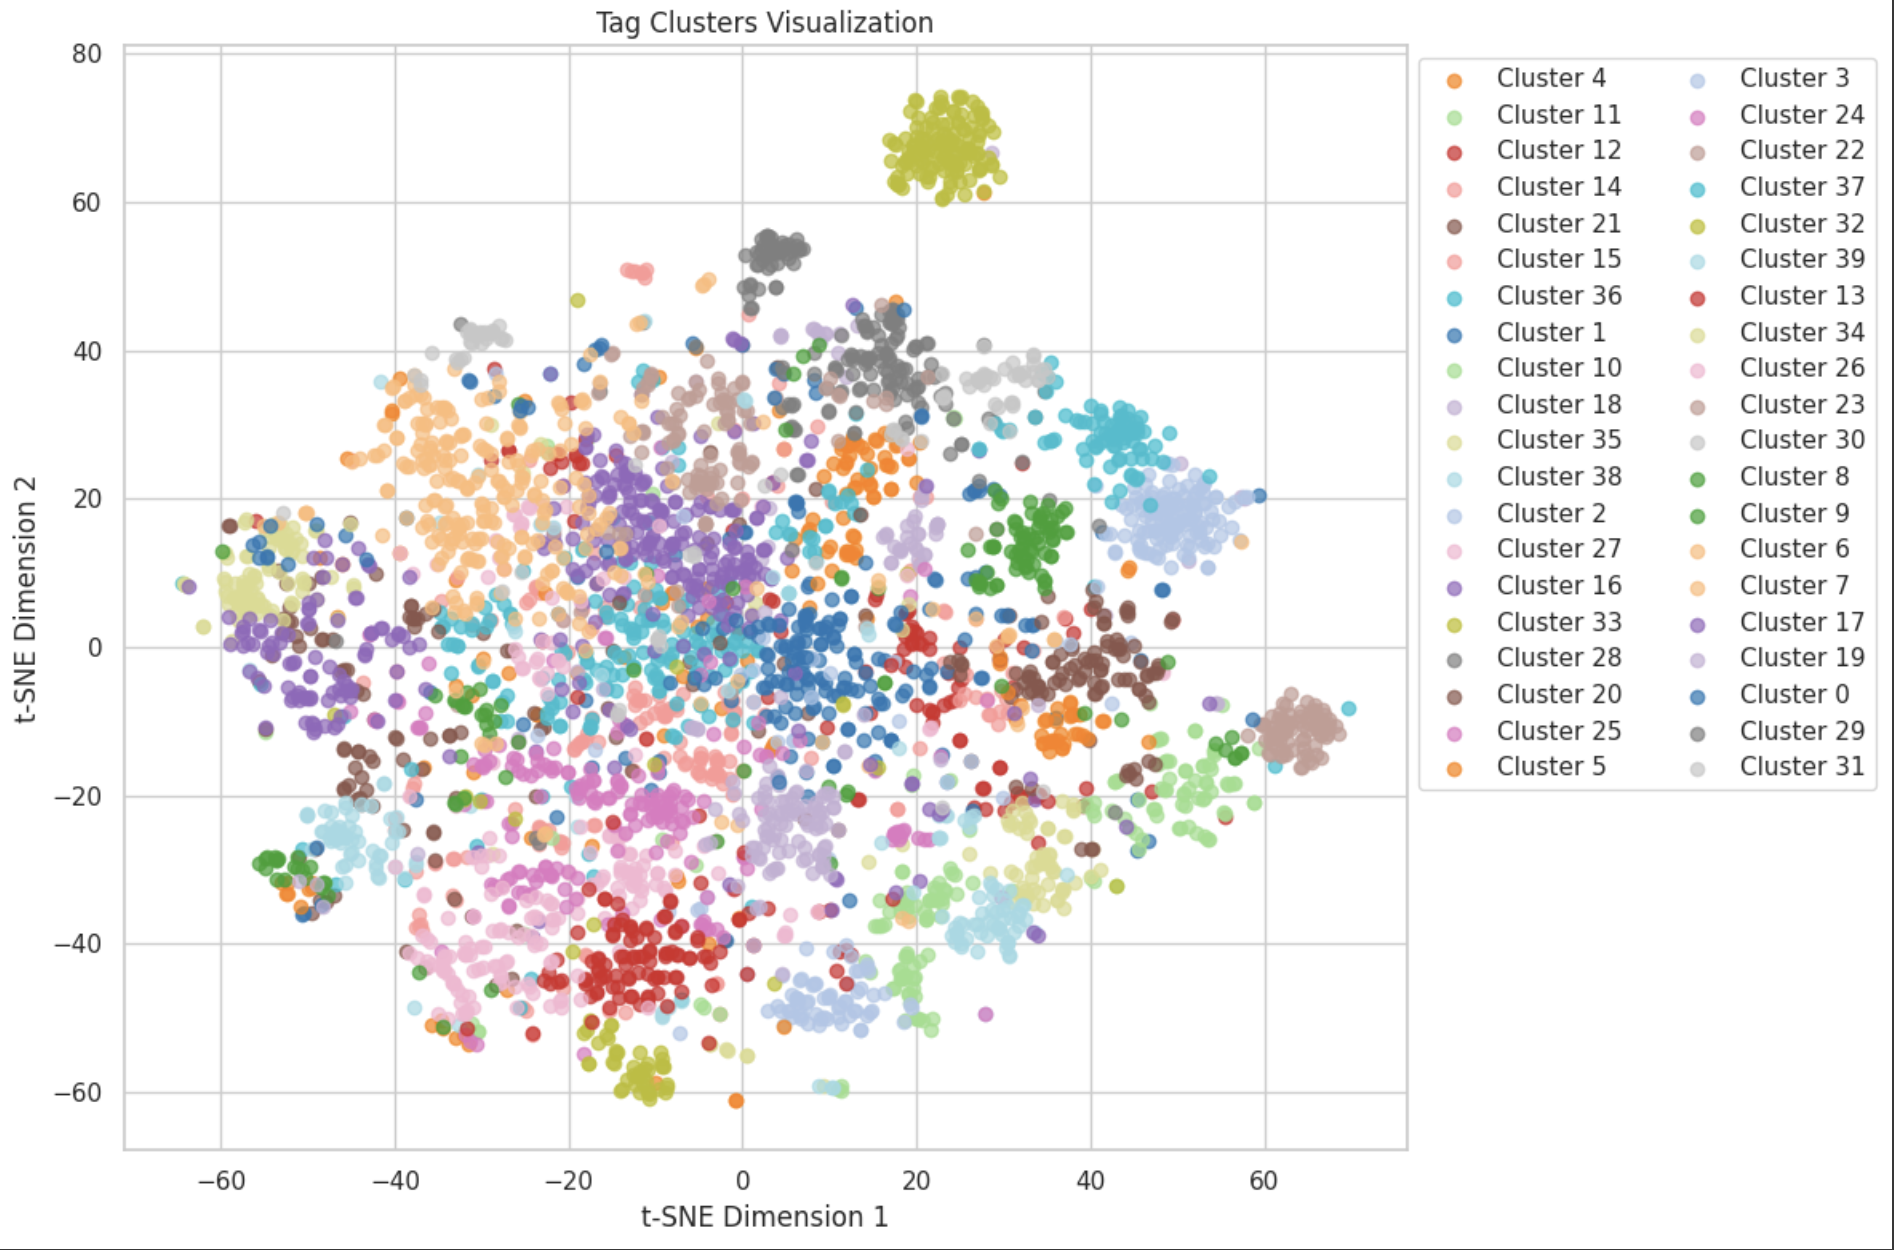

This plot showcases the distribution of tags into 40 clusters, revealing clear separation for some groups while highlighting overlap in others, reflecting the diversity and complexity of the dataset.

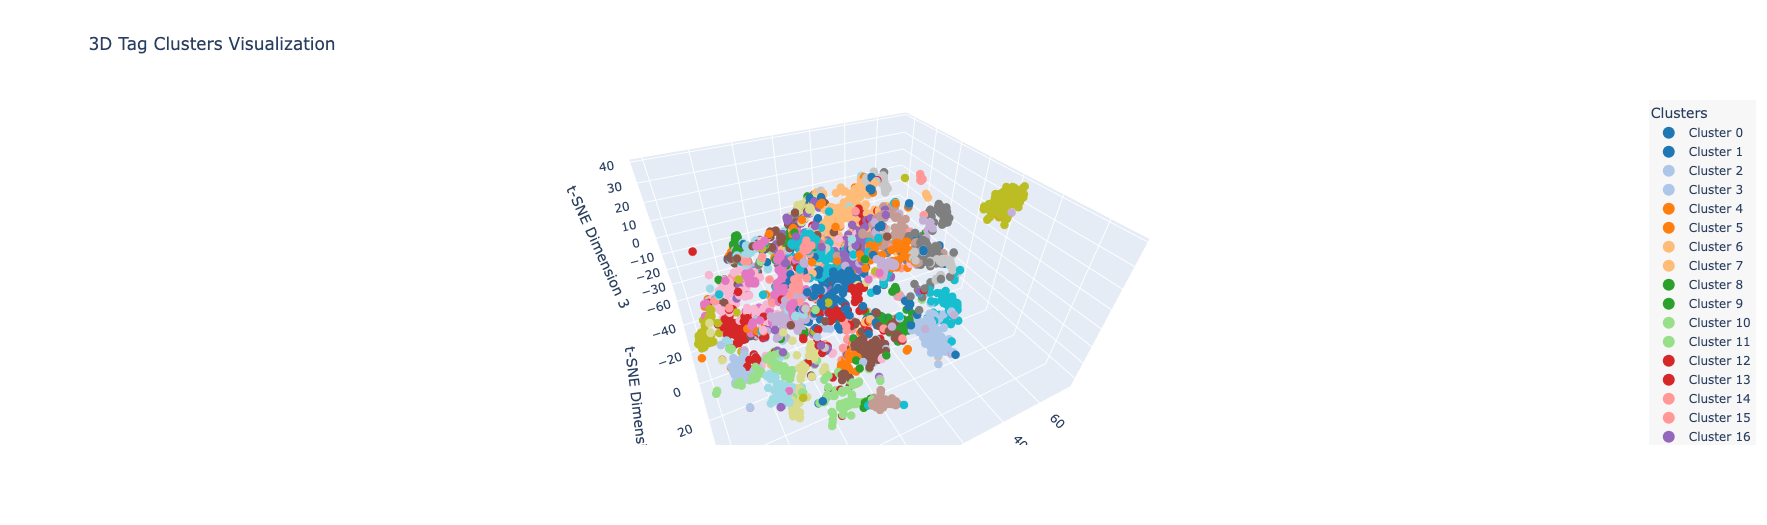

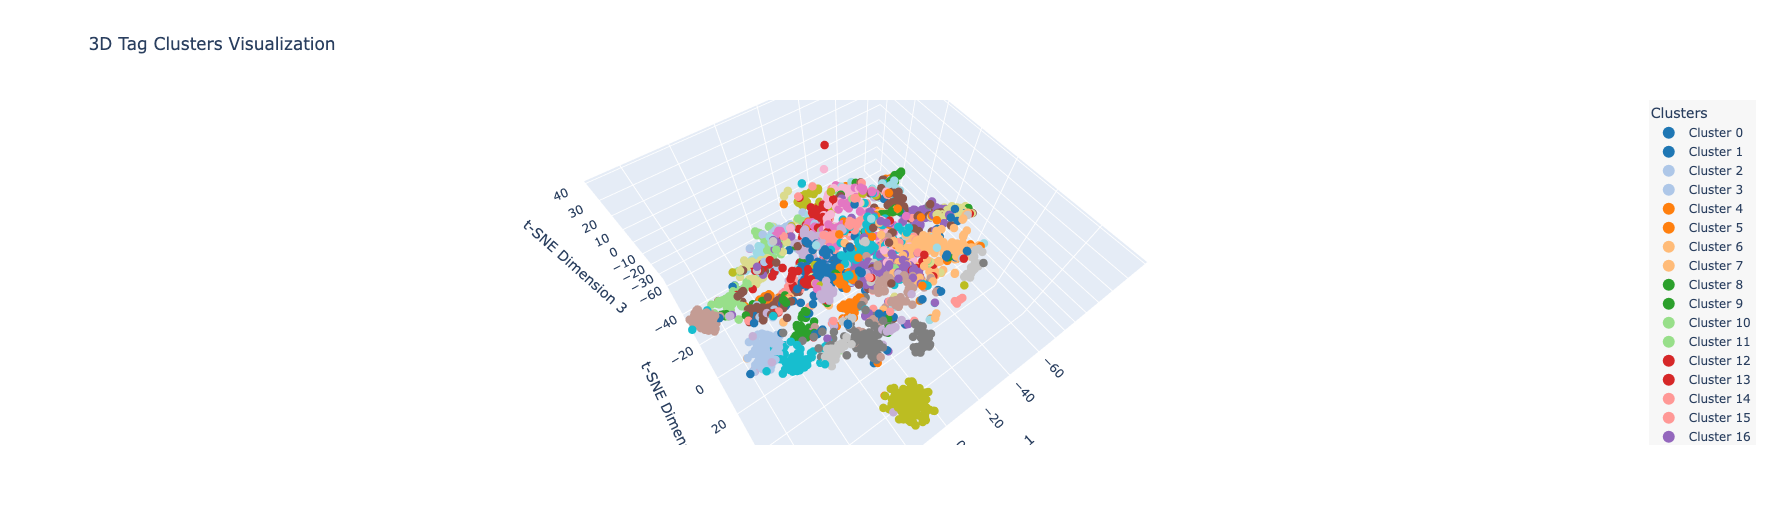

#### Clusters themes

Below are the clusters derived from movie tags, categorized to highlight their unique themes

Cluster 1: Superheroes and Mythology
- Examples: "batman," "merlin," "dark fantasy."

Cluster 2: Fashion and Style
- Examples: "suit," "80's fashion," "robotic exoskeleton."

Cluster 3: Filmmakers and Creators
- Examples: "nolan," "wes craven," "han zimmer."

Cluster 4: Animation and Visuals
- Examples: "disney animated feature," "robotics," "visually stunning."

Cluster 5: War and Espionage
- Examples: "vietnam war," "aviation," "spy team."

Cluster 6: Politics and Dystopia
- Themes of corruption, conspiracies, and global issues.
- Examples: "conspiracy," "propaganda," "climate change."

Cluster 7: Deep Psychological, Philosophical, and Moral Themes
- Examples: "catholicism," "nihilism," "deal with the devil."

Cluster 8: Space, technology, and futuristic adventures.
- Examples: "sci-fi," "space exploration," "cybernetics."

Cluster 9: Characters and Archetypes
- Examples: "villain protagonist," "character study," "weak villain."

Cluster 10: Feminism and Gender
- Examples: "girl power," "femme fatale," "strong woman."

Cluster 11: Sexuality and Explicit Content
- Examples: "bdsm," "r-rated," "sex scene."

Cluster 12: Outsiders and Stereotypes
- Examples: "psychopath," "geeky," "lovecraftian."

Cluster 13: violence and Horror
- Examples: "blood splatter," "prosthetics," "twist downer end."

Cluster 14: Action and Sports
- Examples: "sword fight," "teamwork," "choreography."

Cluster 15: Crime and Revenge
- Examples: "serial killer," "courtroom drama," "heist."

Cluster 16: movie elements
- Examples: "bittersweet," "parody," "dream."

Cluster 17: Settings
- Examples: "mental hospital," "college," "suburbia."

Cluster 18: Music and Soundtracks
- Examples: "great soundtrack," "jazz," "choir."

Cluster 19: non-human characters
- Examples: "talk dog," "giant robot," "werewolf."

Cluster 20: Professions
- Examples: "private investigator," "hacker," "photographer."

Cluster 21: Adventures
- Examples: "road trip," "treasure hunt," "post-apocalyptic."

Cluster 22: Plot Twists
- Examples: "plot twist," "alternate reality," "dream within a dream."

Cluster 23: Iconic Actresses
- Examples: "salma hayek," "emma stone," "scarlett johansson."

Cluster 24: Visual
- Examples: "firework," "golden palm," "great chemistry."

Cluster 25: Death and Afterlife
- Examples: "zombie," "suicide," "afterlife."

Cluster 26: Emotional Drama
- Examples: "depress," "telekinesis," "death-defying stunt."

Cluster 27: Mental helth
- Examples: "short-term memory loss," "psychedelic," "madness."

Cluster 28: Genre Mashups
- Examples: "british comedy," "buddy movie," "horror."

Cluster 29: Literature and Adaptations
- Examples: "philip k. dick," "biography," "base on a novel."

Cluster 30: Cinematic Craftsmanship
- Examples: "stanley kubrick," "oscar," "beautifully film."

Cluster 31: History and Time Travel
- Examples: "1920s," "alternate history," "time travel."

Cluster 32: Weapons and Action
- Examples: "sniper," "revolver," "gunfight."

Cluster 33: References
- Examples: "cultural reference," "movie reference," "biblical reference."

Cluster 34: Global Locations
- Examples: "tokyo," "paris," "new york city."

Cluster 35: Family dynamics and relationships.
- Examples: "family bond," "father-son relationship," "siblings."

Cluster 36: Innovation and AI
- Examples: "time loop," "turing test," "ai."

Cluster 37: Iconic Actors
- Examples: "daniel craig," "keanu reeves," "brad pitt."

Cluster 38: Cars
- Examples: "car chase," "motorcycle," "classic car."

Cluster 39: Romance & relationships
- Examples: "love story," "friendship," "gay romance."

You can interact with this plot in the EDA notebook, exploring the clusters by zooming in, zooming out, and viewing them from different angles.

# Explainablity 👨‍🏫

---

### Data Distribution

Based on the heatmaps shown bellow we can conclude that:

 - Diversity of User Preferences

1. The second heatmap (subset of active users and popular items) shows interactions concentrated around specific users and items, reflecting that some users are highly active and some items are very popular.

2. The first heatmap (subset of 10,000 users and 500 items) shows a more scattered interaction pattern, emphasizing the diversity in user preferences and the sparsity of interactions across the entire dataset.


- The model’s reliance on global trends for less active users and less popular items is evident from the broader heatmap.

- Recommendations for active users and popular items are easier to explain due to stronger interaction signals, as seen in the smaller heatmap.

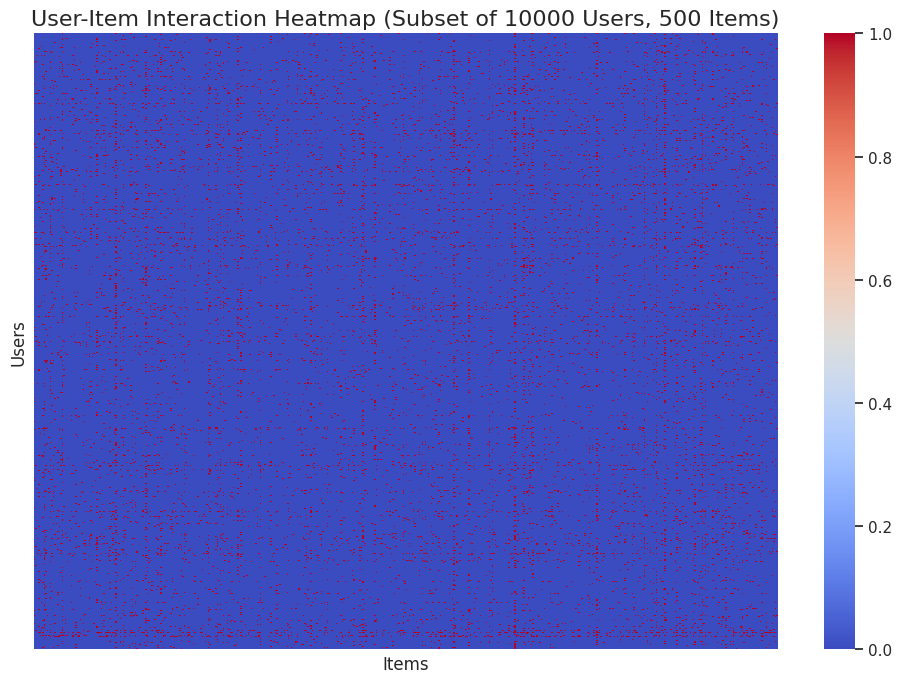

In [ ]:
def plot_interactions_subset(interactions, num_users=500, num_items=500):
    """
    Visualize a subset of the interaction matrix.

    Parameters:
        interactions (scipy.sparse.csr_matrix): The full user-item interaction matrix.
        num_users (int): Number of users to include in the subset.
        num_items (int): Number of items to include in the subset.
    """
    # Convert to CSR format if not already
    if not isinstance(interactions, csr_matrix):
        interactions = interactions.tocsr()

    # Select a random subset of users and items
    user_subset = np.random.choice(interactions.shape[0], num_users, replace=False)
    item_subset = np.random.choice(interactions.shape[1], num_items, replace=False)

    # Slice the matrix and convert the subset to dense
    interactions_subset = interactions[user_subset, :][:, item_subset].toarray()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(interactions_subset, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title(f"User-Item Interaction Heatmap (Subset of {num_users} Users, {num_items} Items)", fontsize=16)
    plt.xlabel("Items")
    plt.ylabel("Users")
    plt.show()

# Visualize a subset
plot_interactions_subset(interactions, num_users=10000, num_items=500)

In [ ]:
sparsity = 100 * (1 - interactions.nnz / (interactions.shape[0] * interactions.shape[1]))
print(f"Matrix Sparsity: {sparsity:.2f}%")

Matrix Sparsity: 96.35%


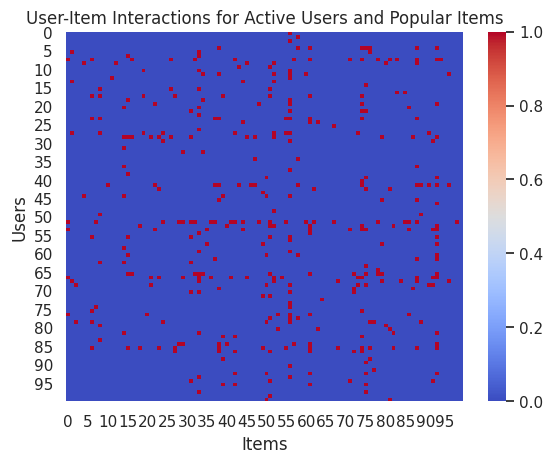

In [ ]:
# Convert the interaction matrix to CSR format
if not isinstance(interactions, csr_matrix):
    interactions = interactions.tocsr()

# Select subsets of users and items
active_users = np.random.choice(interactions.shape[0], size=100, replace=False)
popular_items = np.random.choice(interactions.shape[1], size=100, replace=False)

# Slice the interaction matrix
group_interactions = interactions[active_users, :][:, popular_items].toarray()

# Plot the heatmap
sns.heatmap(group_interactions, cmap="coolwarm")
plt.title("User-Item Interactions for Active Users and Popular Items")
plt.xlabel("Items")
plt.ylabel("Users")
plt.show()

### Ablation Study

To evaluate the significance of each modified module in the architecture, we systematically removed them one at a time and analyzed their impact on the model's performance.


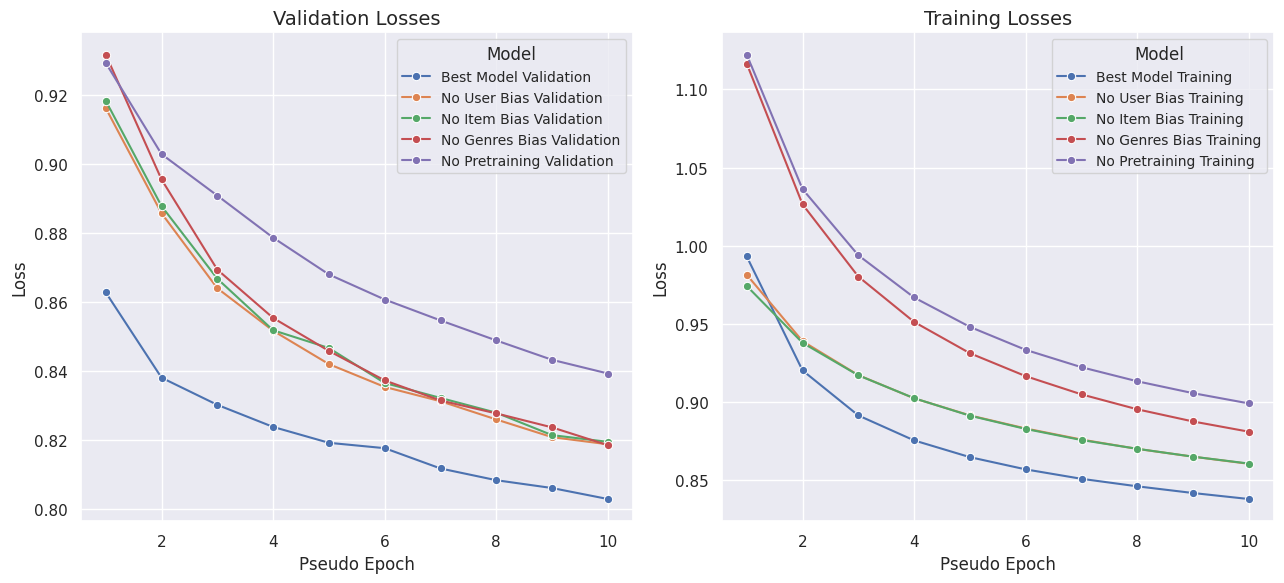

In [ ]:
epochs = list(range(1, 11))

#Baseline
baseline_validation_losses = [0.862867828299584, 0.8381277420772596, 0.830254203987424, 0.8238515786153301, 0.8192448203633566, 0.8176869209415004, 0.8118030430377036, 0.8083991185063127, 0.8061294036843581, 0.8029421378736723]
baseline_train_losses = [0.9931031382535653, 0.9201632808215493, 0.8913526220678654, 0.8753766530387705, 0.8646582516253554, 0.8568285420874193, 0.8507938590354134, 0.8459882852313817, 0.8416982709415822, 0.8378564979662777]
#No user bias
user_bias_validation_losses= [0.9163151723194866, 0.8858221620392115, 0.8640628947197365, 0.8517480552318775, 0.8420626634326749, 0.8354502097271668, 0.8312978646485056, 0.8260145150342538, 0.8208828709618847, 0.818814419901854]
user_bias_train_losses= [0.9814075103755698, 0.9388737149245421, 0.9171694114265345, 0.9023255835349931, 0.8913829401842939, 0.8830152069123791, 0.8759183145786695, 0.869944345568153, 0.8649540337636884, 0.8603835896745707]

#no item bias
item_bias_validation_losses= [0.9184544504825766, 0.8878905662742611, 0.8668299365218919, 0.8518859488191902, 0.8467282549348149, 0.8365950529967467, 0.8322573587225421, 0.8279686269549754, 0.8214677504904211, 0.8195240222386948]
item_bias_train_losses= [0.9742228004027518, 0.9378503293925876, 0.9170401197655921, 0.9023938690297357, 0.8912044512752478, 0.8827100228482472, 0.8756181044751565, 0.8699978616121834, 0.8649641828379752, 0.8605572706608926]

#no genres
genres_bias_validation_losses= [0.931832783270655, 0.8956061718074388, 0.8694574585821204, 0.8554523282465722, 0.8458874285394845, 0.8373343190944218, 0.8315174597781814, 0.8277737842166271, 0.8237127032218303, 0.8185567711676438]
genres_bias_train_losses= [1.1165376071285467, 1.0264622003788386, 0.9802354866989492, 0.9512052261704739, 0.9311835549805548, 0.9165003753131293, 0.9048409162486387, 0.8952814992165752, 0.887488815683959, 0.8809484944577023]

#no pretraining
pretraining_validation_losses= [0.9294158353281446, 0.9029558107504163, 0.8909308496393983, 0.8787334746090584, 0.8680640612116519, 0.8607979983494568, 0.8547366356278675, 0.8489275046508733, 0.8433083981745179, 0.839343129338806]
pretraining_train_losses= [1.1223472396932532, 1.0362181497414407, 0.9938658390360257, 0.9668480350906119, 0.9480357806391202, 0.9333303454916294, 0.9222187106472371, 0.913209293485658, 0.9056118637068024, 0.8990488430526312]

data = []
models = ['Best Model', 'No User Bias', 'No Item Bias', 'No Genres Bias', 'No Pretraining']
validation_losses = [baseline_validation_losses, user_bias_validation_losses, item_bias_validation_losses, genres_bias_validation_losses, pretraining_validation_losses]
training_losses = [baseline_train_losses, user_bias_train_losses, item_bias_train_losses, genres_bias_train_losses, pretraining_train_losses]

for model, val_loss, train_loss in zip(models, validation_losses, training_losses):
    data.extend({'Epoch': epoch, 'Loss': loss, 'Model': f'{model} Validation'} for epoch, loss in zip(epochs, val_loss))
    data.extend({'Epoch': epoch, 'Loss': loss, 'Model': f'{model} Training'} for epoch, loss in zip(epochs, train_loss))

df = pd.DataFrame(data)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Validation losses
sns.lineplot(data=df[df['Model'].str.contains('Validation')], x='Epoch', y='Loss', hue='Model', ax=axes[0], marker='o')
axes[0].set_title('Validation Losses', fontsize=14)
axes[0].set_xlabel('Pseudo Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(title='Model', fontsize=10)

# Training losses
sns.lineplot(data=df[df['Model'].str.contains('Training')], x='Epoch', y='Loss', hue='Model', ax=axes[1], marker='o')
axes[1].set_title('Training Losses', fontsize=14)
axes[1].set_xlabel('Pseudo Epoch', fontsize=12)
axes[1].legend(title='Model', fontsize=10)

plt.tight_layout()
plt.show()

# Appendix 🪦💀
The graveyard for big ideas that we were sure would work, but didn't...

---


This appendix documents various methods and experiments we explored during the project but ultimately did not include in the final submission. These approaches, while promising, either failed to significantly improve performance or were outperformed by other methods.

(1) Retraining

(2) NeuMF Different Architectures

(3) TFRS (TensorFlow Recommenders)

## (1) Retraining


We used our best model to rank the unrated data.
Then, we retrained it on pseudo-labels, hoping to get better results.

Unfortunately, while the training loss kept decreasing - the submission score was lower.


 todo: add a bar chart. 0.83 without retraining, 0.85 with retraining

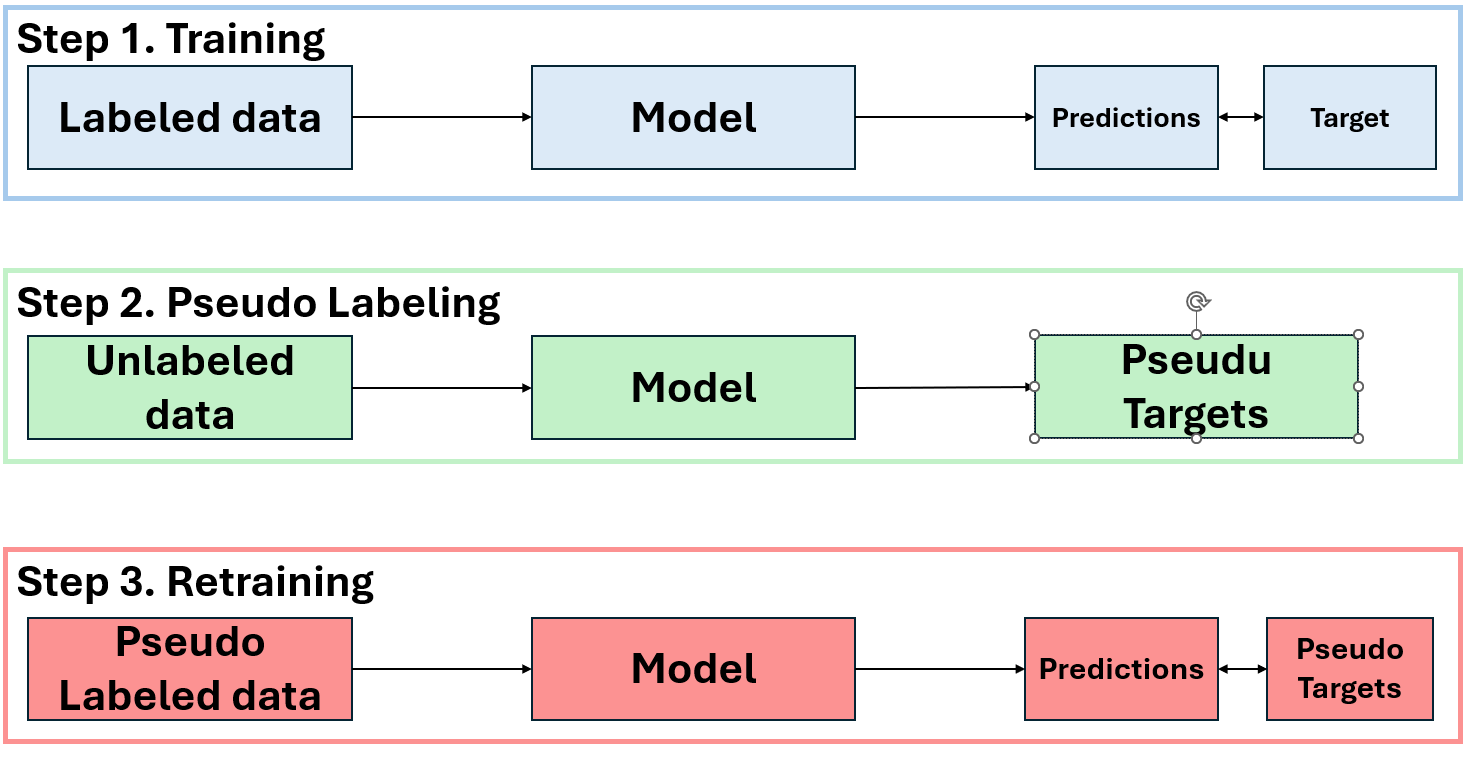

In [ ]:
original_train_df = train_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/train.csv')

In [ ]:
# Load original train data set and filter rated entries
unrated_df = original_train_df[original_train_df["rating"].isnull()]
unrated_df.head()

In [ ]:
# predict with our best model the rating of unrated entries
predict_ratings(unrated_df,model, user_id_to_idx, movie_id_to_idx)

In [ ]:
unrated_df["rating"] = unrated_df["prediction"]

In [ ]:
# weight item and users according to frequencies
add_user_item_weights(unrated_df)

In [ ]:
# Create dataset and dataloader objects for pseudo labeled df

batch_size = 256
# Instantiate the MovieLensDataset
dataset = MovieLensDataset(unrated_df, user_id_to_idx, movie_id_to_idx)
# Create the DataLoader
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)
# Define training parameters
learning_rate = 0.001
epochs = 1

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Now, we re-run our training loop.

## (2) NeuMF Different Architectures


We added user and item metadata in multiple innovative combinations on the NeuMF architectures.

In this section, we lay out the details of each architecture, our thoughts and conclusions.

We also add additional architectural ideas we didn't explore, but believe are very interesting ideas as well!

#### **NeuMF**





- Concatenate `fused_user_gmf = [user_gmf, user_genre]`.
- Concatenate `fused_item_gmf = [item_gmf, item_genre]`.
- We project them to the same dimension using a single linear layer, or small MLPs (2 linear layers a with relu in between).
- Calculate as usual: `fused_user_gmf * fused_item_gmf`.

‼️ **Important Note:**
- Item genres is a multihot sparse vector
- MF module applies elemnt wise multiplication, resulting in zeroing almost all entries every forward pass. This significantly decreased results
- To handle this, we added 1 to `item_genres_multihot`, which significantly improved our results, allowing the MF module to work
- In the rest of the experiments documented in the appendix, the item genres vector is gone through the same transformation to improve results

**Example**:

`[0, 1, 0, 0, 0, 1, 0]` $→$ `[1, 2, 1, 1, 1, 2, 1]`


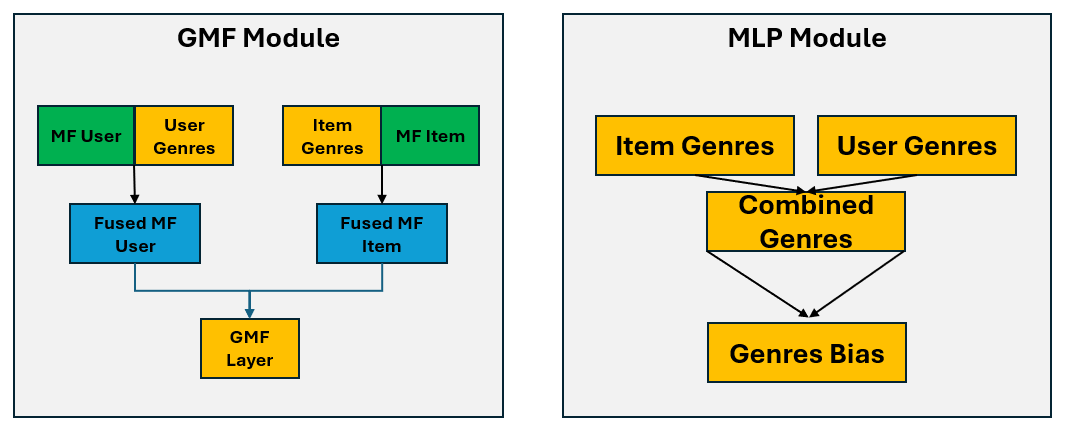

Similarly to the architecture we showed above, instead of fusing `[item_vec, item_genre]` and `[user_vec, user_genre]`, we projected the genre vectors into the same dimensions as the item and user MF vectors, and then applied element-wise product between all of them.

This approach didn't work as good as the first one, we believe possibly due to multiple vectors element-wise operations.

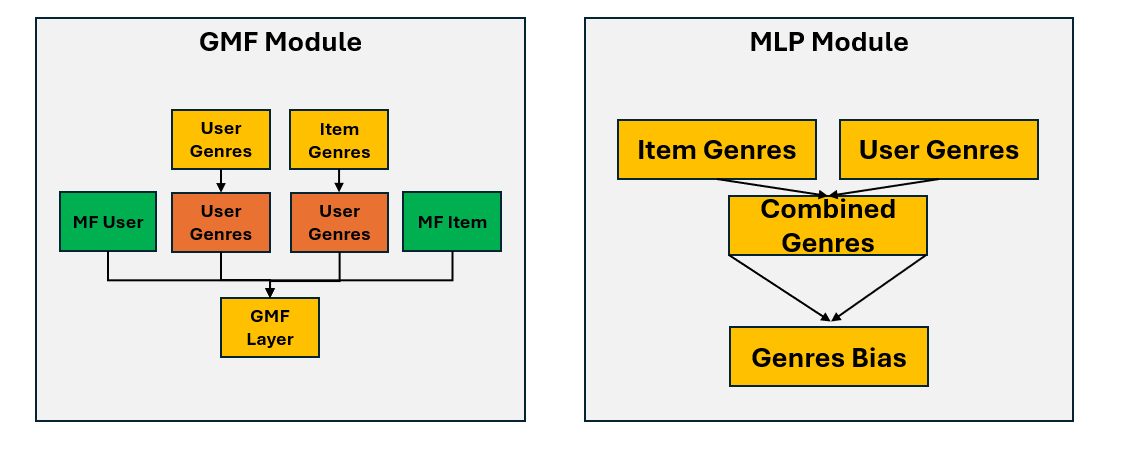

In [ ]:
genre_bias = self.genres_predict_layer(genres_multihot[item_indices])
        prediction = self.predict_layer(combined) + genre_bias

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim, mlp_layers, dropout=0.2, num_classes=10):

        # ... Previous implementation remains the same

        # Final prediction layer
        self.user_genres_projection = nn.Linear(embed_dim + mlp_layers[-1], 30)
        self.item_genres_fusion = nn.Linear(embed_dim + mlp_layers[-1], 30)

        self.regression_predict_layer = nn.Linear(embed_dim + mlp_layers[-1] + 20 + 18, 1)
        self.classification_predict_layer = nn.Linear(embed_dim + mlp_layers[-1] + 20 + 18, num_classes)

    def forward(self, user_indices, item_indices):
        ############### GENRES RETRIEVAL ###############
        user_genres = user_genre_preferences[item_indices]
        item_genres = genres_multihot[item_indices]+1
        ################################################

        ############### GENRES PROJECTION ###############
        projected_user_genres = self.user_genres_projection(user_genres)
        projected_item_genres = self.item_genres_projection(item_genres)
        #################################################

        ############### MODIFIED GMF ####################
        gmf_output = gmf_user * gmf_item * projected_item_genres * projected_user_genres
        #################################################

        #.... Implementation


We also tried simply concatenating the item and user genres to the last NeuMF layer. This approach worked worse for us, possibly due to the fact that we didn't used deep NN to predict a score, but a single linear layer (no non-linearities at all for genres).


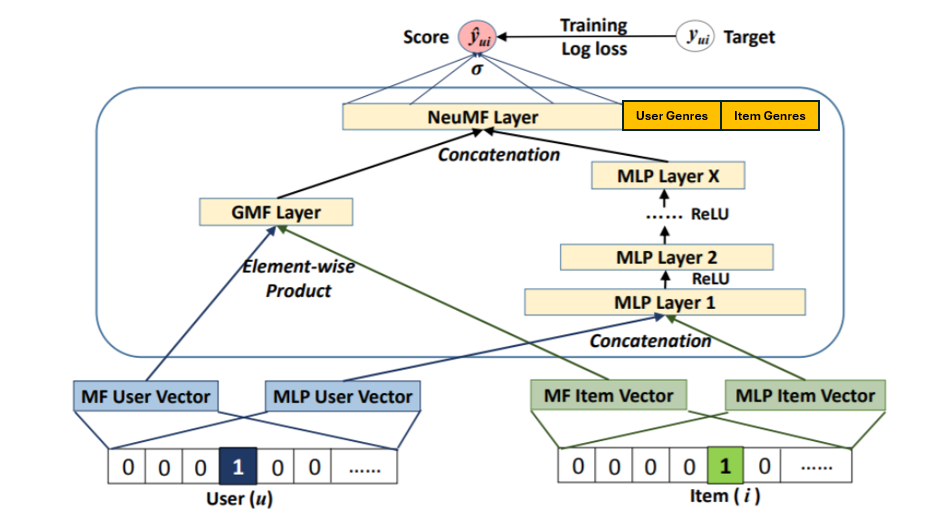

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim, mlp_layers, dropout=0.2, num_classes=10):

        # ... Previous implementation remains the same

        # Final prediction layer
        self.regression_predict_layer = nn.Linear(embed_dim + mlp_layers[-1] + 20 + 18, 1)
        self.classification_predict_layer = nn.Linear(embed_dim + mlp_layers[-1] + 20 + 18, num_classes)

    def forward(self, user_indices, item_indices):
        ############### GENRES RETRIEVAL ###############
        user_genres = user_genre_preferences[item_indices]
        item_genres = genres_multihot[item_indices]+1
        ################################################

        #.... Implementation

        # Concatenate GMF and MLP outputs with the user and item genres
        combined = torch.cat((gmf_output, mlp_output, user_genres, item_genres), dim=-1)

### Final Thoughts

- We tried additionaly removing either the gmf or mlp parts in every architecture. Removing the genres from the MLP decreased the results, while removing the GMF part had minor impacts. perhaps the non-linearities, which are present in the MLP enhance learning with metadata.

- We thought about encoding each item-genre combination as a 1-hot instead of multi-hot encoding, one for each unique combination. Then, learn embeddings for each item genre combination, similar to the item and user embeddings. This could be another interesting approach we didn't get the chance to experiment with.

While we conducted an F-test which assesed our hypothesis that **genres metadata is significantly correlated with ranking**, it did improve our results but not significantly. perhaps there are additional and better ways to incorporate metadata, rather than in the model's core architecture

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim, mlp_layers, dropout=0.2, num_classes=10):
        """
        Parameters:
            num_users (int): Number of unique users.
            num_items (int): Number of unique items.
            embed_dim (int): Embedding dimension for GMF and MLP.
            mlp_layers (list): List containing the number of neurons for each MLP layer.
            dropout (float): Dropout rate for MLP layers.
        """
        super(NeuMF, self).__init__()

        # GMF embeddings
        self.gmf_user_embedding = nn.Embedding(num_users, embed_dim)
        self.gmf_item_embedding = nn.Embedding(num_items, embed_dim)

        self.gmf_user_genre_fusion = nn.Sequential(nn.Linear(embed_dim + 18, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim))
        self.gmf_item_genre_fusion = nn.Sequential(nn.Linear(embed_dim + 20, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim))

        # MLP embeddings
        self.mlp_user_embedding = nn.Embedding(num_users, embed_dim)
        self.mlp_item_embedding = nn.Embedding(num_items, embed_dim)

        # MLP layers
        mlp_input_dim = embed_dim * 2
        mlp_layers_seq = []
        for layer_size in mlp_layers:
            mlp_layers_seq.append(nn.Linear(mlp_input_dim, layer_size))
            mlp_layers_seq.append(nn.ReLU())
            mlp_layers_seq.append(nn.Dropout(dropout))
            mlp_input_dim = layer_size
        self.mlp_layers = nn.Sequential(*mlp_layers_seq)

        # Final prediction layer
        self.regression_predict_layer = nn.Linear(embed_dim + mlp_layers[-1], 1)
        self.classification_predict_layer = nn.Linear(embed_dim + mlp_layers[-1], num_classes)
        self.genres_predict_layer = nn.Sequential(nn.Linear(20 + 18, 10), nn.ReLU(), nn.Linear(10, 1))
        self.genres_fusion_layer = nn.Sequential(nn.Linear(20 + 18, 30))

        # Init
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.gmf_user_embedding.weight, std=0.01)
        nn.init.normal_(self.gmf_item_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_user_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embedding.weight, std=0.01)

        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        nn.init.xavier_uniform_(self.regression_predict_layer.weight)
        nn.init.zeros_(self.regression_predict_layer.bias)

        nn.init.xavier_uniform_(self.classification_predict_layer.weight)
        nn.init.zeros_(self.classification_predict_layer.bias)

    def forward(self, user_indices, item_indices):
        user_genres = user_genre_preferences[item_indices]
        item_genres = genres_multihot[item_indices]+1

        # GMF part
        gmf_user = self.gmf_user_embedding(user_indices)
        gmf_item = self.gmf_item_embedding(item_indices)

        # Here we applied element-wise multiplication between all 4 vectors
        gmf_output = gmf_user * gmf_item * item_genres * user_genres

        # MLP part
        mlp_user = self.mlp_user_embedding(user_indices)
        mlp_item = self.mlp_item_embedding(item_indices)
        mlp_input = torch.cat((mlp_item, mlp_user), dim=-1)

        genres_bias = self.genres_predict_layer(genres_combined)
        mlp_output = self.mlp_layers(mlp_input)

        # Concatenate GMF and MLP outputs
        combined = torch.cat((gmf_output, mlp_output), dim=-1)

        # Final prediction
        #genre_bias = self.genres_predict_layer(genres_multihot[item_indices])
        regression_prediction = self.regression_predict_layer(combined)# + genre_bias
        classification_prediction = self.classification_predict_layer(combined)
        return regression_prediction, classification_prediction

## (3) TFRS

We implemented alternative models using the TensorFlow Recommenders library to compare with our PyTorch-based NeuMF model.

Although TFRS provided a flexible framework, the models we built underperformed compared to our optimized NeuMF implementation.

Here you can find the [notebook](https://colab.research.google.com/drive/1O8UIZ7Js7ki8sPdGHQRSASWY5Gd4Qh4W?usp=sharing)